
# Gas Price Forecast


**Business Overview**: You work at Trucks Inc. Your company with a marketplace business model, the company brings together Self-Employed Truck Drivers and Third Party Truck Drivers with other companies that need a truck driver to move all types of materials, such as gasoline, food (processed or not, for example, frozen meat, forzen fruits, cotton, wheat, seasonings, drinks of all types and so on) all these products are requested by companies that need a truck driver.
One side of the marketplace are companies, they all need to create an account with valid credentials and request a driver for specific locations, risk, time range to complete, intervals, priority and the company can price the trip reward or not, to all positions. of travel, Trucks Inc receives a per postage a fee.
On the other side of the marketplace are self-employed truck drivers or third-party drivers, everyone also needs to create a truck driver account and find all the trips available for them to join, after the truck driver choise the traveling, the Truck Inc make a Interview with Driver and Third Company for validate the traveling and completes the process of marketplace.

**Business Problem**: At Trucks Inc, you need to expand the marketing campaign to acquire new self-employed truck drivers, one of the hypotheses raised by the Head of Marketing was to use the price of gasoline as an incentive to attract the attention of truck drivers, as the company has a lot of trips in progress. currently open but there are around 50% of active truck drivers on the platform, so the Head of Marketing has a proposal to pay 50% of the fuel needed for the truck driver's trip if he completes a trip on the platform.
In this scenario, you need to forecast the gas price for all regions and give a statistics overview of all available regions based on gas price for for Head of Marketing decisions.


## 0.0. Requirements


### 0.1. Imports

In [ ]:
import re
import uuid
import mlflow
import logging
import optuna
import hyperopt

import numpy as np
import pandas as pd
import seaborn as sns

from time import sleep
from calendar import month_abbr
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from databricks import feature_store

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from xgboost import XGBRegressor
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from statsforecast import StatsForecast
from statsforecast.models import (
    MSTL,
    AutoETS,
    AutoCES,
    AutoTheta,
    AutoARIMA
)

from window_ops.ewm import ewm_mean
from window_ops.expanding import expanding_mean

from window_ops.rolling import (
    rolling_mean,
    seasonal_rolling_mean,
    rolling_min,
    rolling_max,
    rolling_std
)


from sklearn.base import BaseEstimator
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor 

from pyspark.sql import functions as pf

from warnings import filterwarnings

filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go

#from geopy.geocoders import Nominatim
#agent = Nominatim(user_agent="abc")

In [ ]:
!pip freeze

absl-py==1.0.0
adagio==0.2.4
alembic==1.13.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
astor==0.8.1
asttokens==2.0.5
astunparse==1.6.3
attrs==21.4.0
azure-core==1.26.3
azure-cosmos==4.2.0
backcall==0.2.0
backports.entry-points-selectable==1.2.0
bcrypt==3.2.0
beautifulsoup4==4.11.1
black==22.3.0
bleach==4.1.0
blis==0.7.9
boto3==1.21.32
botocore==1.24.32
cachetools==4.2.2
catalogue==2.0.8
category-encoders==2.5.1.post0
certifi==2021.10.8
cffi==1.15.0
chardet==4.0.0
charset-normalizer==2.0.4
click==8.0.4
cloudpickle==2.0.0
cmdstanpy==1.1.0
colorlog==6.8.2
confection==0.0.4
configparser==5.2.0
convertdate==2.4.0
coreforecast==0.0.9
cryptography==3.4.8
cycler==0.11.0
cymem==2.0.7
Cython==0.29.28
databricks-automl-runtime==0.2.15
databricks-cli==0.17.4
databricks-feature-store==0.10.1
dbl-tempo==0.1.12
dbus-python==1.2.16
debugpy==1.5.1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.4
diskcache==5.4.0
distlib==0.3.6
distro==1.4.0
distro-info==0.23+ubuntu1.1
docstring-to-m


### 0.2. Aux Functions

In [ ]:
def plot_diff_acf(
    dff: pd.DataFrame,
    region: str
):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    price = dff.loc[dff["region"] == region, "price"]
    price.plot(x="date", y="price", grid=2, title=region, ax=ax[0])
    price.diff().plot(x="date", y="price", grid=2, title=region, ax=ax[2])

    plot_acf(price, lags=range(1, 50), ax=ax[1])
    plot_acf(price.diff().dropna(), lags=range(1, 50), ax=ax[3])

    for axi in ax: axi.grid(2);

    plt.tight_layout();

def plot_seasons_year_month(
    df3: pd.DataFrame,
    m_col="month",
    yr_col="year",
    y="price"
):
    df3p = df3[[m_col, yr_col, y]].groupby([yr_col, m_col]).sum(y).reset_index()
    df3p = df3p.sort_values(by=[yr_col, m_col])

    fig, ax = plt.subplots(figsize=(15,10))
    plt.xticks(
        ticks=range(1, len(df3p[m_col].unique()) + 1), 
        labels=[month_abbr[k] for k in set(df3p[m_col].unique())]
    )

    for variable in df3p[yr_col].unique():
        aux = df3p[df3p[yr_col] == variable]
        ax.plot(aux[m_col], aux[y], label=variable)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title('Gas Price by Month and Year')
    ax.grid(2)

def plot_seasons_quarter_month(
    df3 = pd.DataFrame,
    yr_col="year",
    q_col="quarter",
    y="price"
):
    fig, ax = plt.subplots(2, 2, figsize=(10,6))
    ax = ax.flatten()

    df3p = df3[[y, yr_col, q_col]].groupby([yr_col, q_col]).sum(y).reset_index()
    df3p = df3p.sort_values(by=[yr_col, q_col])

    for i, q in enumerate(df3p[q_col].unique()):
        axis = df3p.loc[df3p[q_col] == q, [y, q_col, yr_col]].plot(
            kind="line", x=yr_col, y=y, 
            label= f'Q{q}', ax=ax[i], color="k", grid=2
        )
        axis = axis.get_children()[0]
        
        ax[i].hlines(
            y=np.mean(axis.get_ydata()), 
            xmin=axis.get_xdata()[0], 
            xmax=axis.get_xdata()[-1],
            color='b'
        )
        
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation=45)

    plt.tight_layout()

In [ ]:
def get_ml_metrics(
    df: pd.DataFrame,
    ytrue: str = "price",
    yhat: str = "yhat",
    return_df = False,
    k: int = 1
):
    r2 = r2_score(df[ytrue], df[yhat])
    mse = mean_squared_error(df[ytrue], df[yhat])
    rmse = np.sqrt(mean_squared_error(df[ytrue], df[yhat]))

    df["resid"] = df[ytrue] - df[yhat]
    df = df.sort_values("resid")

    resid_sum = df["resid"].sum()

    try:
        _, pval_s = stats.shapiro(df["resid"])
        _, pval_n = stats.normaltest(df["resid"])

    except:
        pval_s = 0
        pval_n = 0

    metrics = {"r2": r2, "mse": mse, "rmse": rmse,
        "sred": resid_sum, "pv_shap": pval_s, "pv_norm": pval_n, "k": k
    }

    if return_df:
        return metrics, df
    
    else:
        return metrics

def plot_resid_analysis(
    df_test: pd.DataFrame,
    x: str = "date",
    ytrue: str = "price",
    yhat: str = "yhat",
    region: str = None,
    region_col: str = "unique_id",
):
    if region:
        test = df_test[df_test[region_col] == region]

    else:
        test = df_test[[x, ytrue, yhat]].groupby(x).sum().reset_index()

    metrics, test = get_ml_metrics(test, return_df=True, yhat=yhat, ytrue=ytrue)

    fig, _, = plt.subplots(figsize=(15,10))
    ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
    ax1 = plt.subplot2grid((3, 3), (1, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 1))
    ax3 = plt.subplot2grid((3, 3), (1, 2))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=3);

    test.plot(x=x, y="resid", marker="o", color="k", ax=ax0)
    sns.scatterplot(x=test[ytrue], y=test[yhat], ax=ax1)

    ax2.hist(test["resid"], bins=20)
    stats.probplot(test["resid"], plot=ax3)
    plot_acf(test["resid"], lags=range(1, len(test)), ax=ax4);
    ax3.annotate(f"SW P: {metrics['pv_shap']:.4f}\nNT P: {metrics['pv_norm']:.4f}\n$\\sum e$: {metrics['sred']:.4f}", xy=(0.05, 0.7), xycoords='axes fraction', fontsize=10)

    for axi in [ax0, ax1, ax2, ax3, ax4]:
        axi.grid(2)

    plt.tight_layout()

    return fig, metrics

def plot_future_multiple_forecasting(
    df_history: pd.DataFrame,
    df_forecasting: pd.DataFrame,
    plot_unique_ids: list = ["us", "san_francisco", "ohio"],
    forecasting_col: str = "MSTL",
    target_col: str = "y",
    date_col: str = "ds",
    unique_id_col: str = "unique_id"
):
    fig, ax = plt.subplots(figsize=(13, 6))
    for unique_id in df_forecasting[unique_id_col].unique():
        dfp = df_forecasting[df_forecasting[unique_id_col] == unique_id]
        
        if unique_id in plot_unique_ids:
            df_history[(df_history[unique_id_col] == unique_id) & (df_history[date_col] >= "2024-01-01")].plot(x=date_col, y=target_col, color="k", linestyle="--", ax=ax, label=unique_id)
            dfp.plot(x=date_col, y=forecasting_col, label=unique_id, ax=ax, linestyle="--")

        else:
            dfp.plot(x=date_col, y=forecasting_col, label=unique_id, ax=ax)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title("Forecasting")
    ax.grid(2)

    return fig


def plot_train_test_forecast(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    date_col: str,
    ytrue: str,
    yhat: str
):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.grid(2)
    ax.set_title("Train, Test and Forecast")

    df_train.plot(x=date_col, y=ytrue, ax=ax, color="k", label="train")
    df_test.plot(x=date_col, y=ytrue, ax=ax, color="r", label="true")
    df_test.plot(x=date_col, y=yhat, ax=ax, label="yhat", color="b", linestyle="--", grid=2);

    return fig

In [ ]:
def prequential_sliding_blocks(
    df: pd.DataFrame,
    gap_months: int = 1,
    validation_months: int = 4,
    cutoff_date: datetime = datetime(2021, 1, 1),
    plot_interval: bool = False,
    date_col: str = "date",
    target_col: str = "price"
):

    train_idx_list = []
    valid_idx_list = []

    while df[date_col].max() >= cutoff_date:
        # Training and Valid with one month gap pandas spliting
        start_cutoff_date_gap = (cutoff_date + pd.DateOffset(months=gap_months)).strftime("%Y-%m") + "-01"
        end_cutoff_end_date_gap = (cutoff_date + pd.DateOffset(months=gap_months + validation_months)).strftime("%Y-%m") + "-01"

        df_train = df[df[date_col] < cutoff_date.strftime("%Y-%m-%d")]
        df_valid = df[(df[date_col] > start_cutoff_date_gap) & (df[date_col] < end_cutoff_end_date_gap)]

        # if do not have data, than break
        if df_valid.empty: break

        if plot_interval:
            ax = df_train.plot(x=date_col, y=target_col, label="train", figsize=(8, 4))
            df_valid.plot(x=date_col, y=target_col, color="r", ax=ax, label="valid", grid=2)
            ax.set_title(f"Valid: {df_valid[date_col].min().strftime('%Y-%m-%d')} -> {df_valid[date_col].max().strftime('%Y-%m-%d')}");

        cutoff_date += pd.DateOffset(months=validation_months)

        train_idx_list.append(df_train.index.values)
        valid_idx_list.append(df_valid.index.values)

    return train_idx_list, valid_idx_list

def describe_ml_metrics(
    metrics_list: list[dict]
) -> tuple:
    k_fold_metrics = pd.DataFrame(metrics_list)
    k_fold_metrics.sort_values(by="k", inplace=True, ascending=True)

    if "estimator" not in k_fold_metrics.columns: k_fold_metrics["estimator"] = "base"
    desc_metrics = k_fold_metrics.groupby("estimator").apply(lambda x: x.describe()).T
    
    log_mean_metrics, log_std_metrics = [], []
    for estimator_name in {j[0] for j in desc_metrics.columns}:
        log_mean_metrics.append({"m_" + k: v for k, v in desc_metrics[estimator_name]["mean"].to_dict().items()} | {"estimator": estimator_name})
        log_std_metrics.append({"s_" + k: v for k, v in desc_metrics[estimator_name]["std"].to_dict().items()} | {"estimator": estimator_name})

    return log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics


def cv_mean_baseline(
    df: pd.DataFrame,
    model: BaseEstimator,
    verbose: bool = False,
    plot_interval: bool = False,
    date_col: str = "date",
    target_col: str = "price",
    unique_id_col: str = "unique_id",
    estimator_name: str = "base",
    base_sklearn = None
):
    train_idx_list, valid_idx_list = prequential_sliding_blocks(
        df=df,
        date_col=date_col,
        target_col=target_col,
        plot_interval=plot_interval
    )

    cv_metrics = []
    for k, index in enumerate(zip(train_idx_list, valid_idx_list)):
        k += 1
        ti, vi = index
        df_train = df[df.index.isin(ti)].reset_index(drop=True)
        df_valid = df[df.index.isin(vi)].reset_index(drop=True)

        y_train = df_train[target_col]
        y_valid = df_valid[target_col]

        if base_sklearn:
            df_train.drop(columns=[date_col, target_col], inplace=True)
            model.fit(df_train, y_train)

        else:
            model.fit(df_train)

        if type(model) == StatsForecast or type(model) == MLForecast:
            forecastings = model.predict(h=df_valid[date_col].nunique()).reset_index()
            if "index" in forecastings.columns:
                forecastings.drop(columns="index", axis=1, inplace=True)

            estimator_list = forecastings.drop(columns=[date_col, unique_id_col], axis=1).columns.values

            for estimator_name in estimator_list:
                model_forecastings = forecastings[[date_col, unique_id_col, estimator_name]].rename(columns={estimator_name: "yhat"})
                model_forecastings = pd.merge(df_valid, model_forecastings, on=[date_col, unique_id_col])

                metrics = get_ml_metrics(model_forecastings, ytrue=target_col, k=k)
                metrics = metrics | {"estimator": estimator_name}
                cv_metrics.append(metrics)

        else:
            model_forecastings = model.predict(df_valid[df_train.columns])

            if type(model_forecastings) == np.ndarray:
                model_forecastings = pd.DataFrame({"yhat": model_forecastings, target_col: df_valid[target_col].values, "date_col": df_valid[date_col].values})

            metrics = get_ml_metrics(model_forecastings, ytrue=target_col, k=k)
            metrics = metrics | {"estimator": estimator_name}
            cv_metrics.append(metrics)
    
    return cv_metrics


In [ ]:
class MeanEstimator(BaseEstimator):
    def __init__(
        self, 
        *,
        estimator_name: str = "MeanEstimator",
        target_col: str = "price",
        unique_id_col: str = "region",
        date_col: str = "date"
    ):
        self.estimator_name = estimator_name
        self.target_col = target_col
        self.unique_id_col = unique_id_col
        self.date_col = date_col
        self.X = None
    
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def predict(self, X):
        means = self.X[[self.unique_id_col, self.target_col]].groupby(self.unique_id_col).mean().reset_index().rename(columns={self.target_col: "yhat"})
        return pd.merge(X[[self.date_col, self.unique_id_col, self.target_col]].reset_index(drop=2), means, on=["region"])


### 0.3. Load Data

In [ ]:
df = spark.read.format("delta").load(f"s3://{silver_bucket_name}/gas")

# If append and partitioned by data_base on silver too 
df = df.filter(pf.col("data_base") == df.select(pf.max(pf.col("data_base"))).collect()[0][0])

df = df.toPandas()
df.drop(columns=["data_base"], axis=1, inplace=True)

In [ ]:
df.head()

us 
 east_coast 
 new_england 
 central_atlantic 
 lower_atlantic 
 midwest 
 gulf_coast 
 rocky_mountain 
 west_coast 
 california 
 colorado 
 florida 
 massachusetts 
 minnesota 
 new_york 
 ohio 
 texas 
 washington 
 boston_ma 
 chicago 
 cleveland_oh 
 denver 
 houston 
 los_angeles 
 miami_fl 
 new_york_city 
 san_francisco 
 seattle_wa 
 date 
 
 
 
 
 0 
 1.068 
 1.040 
 1.068 
 1.068 
 1.023 
 1.061 
 1.064 
 1.093 
 1.152 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-05 
 
 
 1 
 1.079 
 1.047 
 1.073 
 1.072 
 1.032 
 1.077 
 1.071 
 1.118 
 1.154 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-12 
 
 
 2 
 1.079 
 1.054 
 1.074 
 1.077 
 1.040 
 1.067 
 1.081 
 1.120 
 1.155 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-19 
 
 
 3 
 1.086 
 1.059 
 1.076 
 1.080 
 1.046 
 1.078 
 1.081 
 1.169 
 1.157 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-26 
 
 
 4 
 1.086 
 1.062 
 1.080 
 1.084 
 1.050 
 1.073 
 1.084 
 1.161 
 1.161 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-05-03


## 1.0. Descriptive Statistics

In [ ]:
df1 = df.copy()


### 1.1. Dataset Dimension

In [ ]:
print(f"Number of Cols: {df1.shape[1]}")
print(f"Number of Rows: {df1.shape[0]}")

Number of Cols: 29
Number of Rows: 1623



### 1.2. Check Dtypes

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   us                1623 non-null   float64       
 1   east_coast        1623 non-null   float64       
 2   new_england       1623 non-null   float64       
 3   central_atlantic  1623 non-null   float64       
 4   lower_atlantic    1623 non-null   float64       
 5   midwest           1623 non-null   float64       
 6   gulf_coast        1623 non-null   float64       
 7   rocky_mountain    1623 non-null   float64       
 8   west_coast        1623 non-null   float64       
 9   california        1251 non-null   float64       
 10  colorado          1249 non-null   float64       
 11  florida           1094 non-null   float64       
 12  massachusetts     1094 non-null   float64       
 13  minnesota         1249 non-null   float64       
 14  new_york          1249 n


### 1.3. Check Missing Values

In [ ]:
df1.isna().sum() / len(df)

Out[28]: us                  0.000000
east_coast          0.000000
new_england         0.000000
central_atlantic    0.000000
lower_atlantic      0.000000
midwest             0.000000
gulf_coast          0.000000
rocky_mountain      0.000000
west_coast          0.000000
california          0.229205
colorado            0.230437
florida             0.325940
massachusetts       0.325940
minnesota           0.230437
new_york            0.230437
ohio                0.325940
texas               0.230437
washington          0.325940
boston_ma           0.325940
chicago             0.230437
cleveland_oh        0.325940
denver              0.230437
houston             0.230437
los_angeles         0.230437
miami_fl            0.326556
new_york_city       0.230437
san_francisco       0.230437
seattle_wa          0.325940
date                0.000000
dtype: float64


### 1.4. Descriptive Statistics


#### 1.4.1. Numerical Attributes

In [ ]:
dfn = df1.drop(columns=["date"], axis=1)

In [ ]:
df1.date.min(), df1.date.max()

Out[36]: (Timestamp('1993-04-05 00:00:00'), Timestamp('2024-05-06 00:00:00'))

In [ ]:
metrics = pd.concat([dfn.describe().T, dfn.apply(lambda x: x.kurtosis()), dfn.apply(lambda x: x.skew())], axis=1)
metrics.columns = metrics.columns[:-2].tolist() + ["kurtosis", "skew"]

metrics.style.highlight_max(color="yellow", subset=(metrics.columns[1:])).highlight_min(color="cyan").format("{:.2f}")

count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 kurtosis 
 skew 
 
 
 
 
 us 
 1623.00 
 2.36 
 0.95 
 0.95 
 1.44 
 2.37 
 3.09 
 5.11 
 -1.07 
 0.20 
 
 
 east_coast 
 1623.00 
 2.34 
 0.94 
 0.94 
 1.42 
 2.37 
 3.07 
 4.94 
 -1.11 
 0.18 
 
 
 new_england 
 1623.00 
 2.39 
 0.95 
 0.99 
 1.48 
 2.39 
 3.12 
 5.11 
 -1.03 
 0.25 
 
 
 central_atlantic 
 1623.00 
 2.41 
 0.96 
 0.98 
 1.47 
 2.46 
 3.13 
 5.08 
 -1.09 
 0.17 
 
 
 lower_atlantic 
 1623.00 
 2.28 
 0.92 
 0.91 
 1.37 
 2.32 
 3.01 
 4.80 
 -1.13 
 0.18 
 
 
 midwest 
 1623.00 
 2.28 
 0.92 
 0.89 
 1.40 
 2.28 
 3.00 
 5.04 
 -1.03 
 0.24 
 
 
 gulf_coast 
 1623.00 
 2.19 
 0.86 
 0.92 
 1.36 
 2.18 
 2.88 
 4.71 
 -1.02 
 0.28 
 
 
 rocky_mountain 
 1623.00 
 2.36 
 0.94 
 0.99 
 1.45 
 2.36 
 3.06 
 5.12 
 -1.00 
 0.26 
 
 
 west_coast 
 1623.00 
 2.69 
 1.13 
 1.10 
 1.57 
 2.80 
 3.54 
 5.98 
 -0.80 
 0.28 
 
 
 california 
 1251.00 
 3.23 
 1.01 
 1.15 
 2.53 
 3.19 
 3.90 
 6.36 
 -0.10 
 0.27 
 
 
 colorado 
 1249.00 
 2.66 
 0.78 
 1.08 
 2.10 
 2.64 
 3.25 
 5.00 
 -0.68 
 0.13 
 
 
 florida 
 1094.00 
 2.83 
 0.65 
 1.49 
 2.33 
 2.77 
 3.39 
 4.94 
 -0.60 
 0.20 
 
 
 massachusetts 
 1094.00 
 2.87 
 0.69 
 1.52 
 2.34 
 2.77 
 3.49 
 5.15 
 -0.47 
 0.27 
 
 
 minnesota 
 1249.00 
 2.59 
 0.76 
 1.01 
 2.02 
 2.57 
 3.20 
 4.80 
 -0.76 
 0.14 
 
 
 new_york 
 1249.00 
 2.85 
 0.80 
 1.22 
 2.26 
 2.84 
 3.52 
 5.03 
 -0.78 
 0.05 
 
 
 ohio 
 1094.00 
 2.78 
 0.68 
 1.40 
 2.26 
 2.73 
 3.33 
 5.10 
 -0.55 
 0.22 
 
 
 texas 
 1249.00 
 2.50 
 0.74 
 1.04 
 1.94 
 2.49 
 3.06 
 4.72 
 -0.74 
 0.14 
 
 
 washington 
 1094.00 
 3.19 
 0.78 
 1.54 
 2.69 
 3.10 
 3.79 
 5.50 
 -0.10 
 0.31 
 
 
 boston_ma 
 1094.00 
 2.88 
 0.69 
 1.53 
 2.33 
 2.77 
 3.49 
 5.18 
 -0.42 
 0.29 
 
 
 chicago 
 1249.00 
 2.87 
 0.89 
 1.12 
 2.24 
 2.84 
 3.54 
 5.93 
 -0.43 
 0.23 
 
 
 cleveland_oh 
 1094.00 
 2.80 
 0.68 
 1.41 
 2.28 
 2.75 
 3.36 
 5.11 
 -0.54 
 0.22 
 
 
 denver 
 1249.00 
 2.65 
 0.78 
 1.06 
 2.10 
 2.63 
 3.23 
 4.99 
 -0.68 
 0.13 
 
 
 houston 
 1249.00 
 2.49 
 0.74 
 1.01 
 1.93 
 2.49 
 3.05 
 4.72 
 -0.71 
 0.16 
 
 
 los_angeles 
 1249.00 
 3.25 
 1.03 
 1.01 
 2.55 
 3.19 
 3.94 
 6.33 
 -0.15 
 0.19 
 
 
 miami_fl 
 1093.00 
 2.96 
 0.66 
 1.56 
 2.50 
 2.89 
 3.53 
 4.99 
 -0.55 
 0.13 
 
 
 new_york_city 
 1249.00 
 2.77 
 0.79 
 1.18 
 2.21 
 2.75 
 3.45 
 5.11 
 -0.72 
 0.09 
 
 
 san_francisco 
 1249.00 
 3.29 
 1.01 
 1.28 
 2.56 
 3.27 
 3.94 
 6.50 
 -0.04 
 0.34 
 
 
 seattle_wa 
 1094.00 
 3.24 
 0.82 
 1.51 
 2.72 
 3.13 
 3.82 
 5.64 
 -0.03 
 0.34

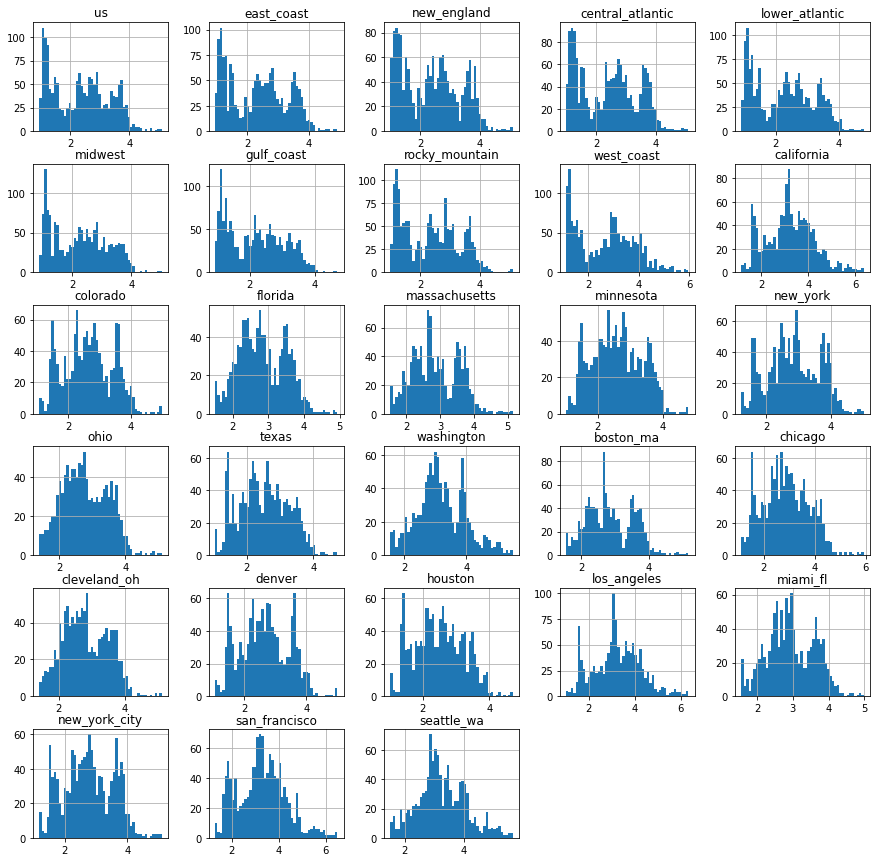

In [ ]:
dfn.hist(
    bins=50,
    figsize=(15,15)
);

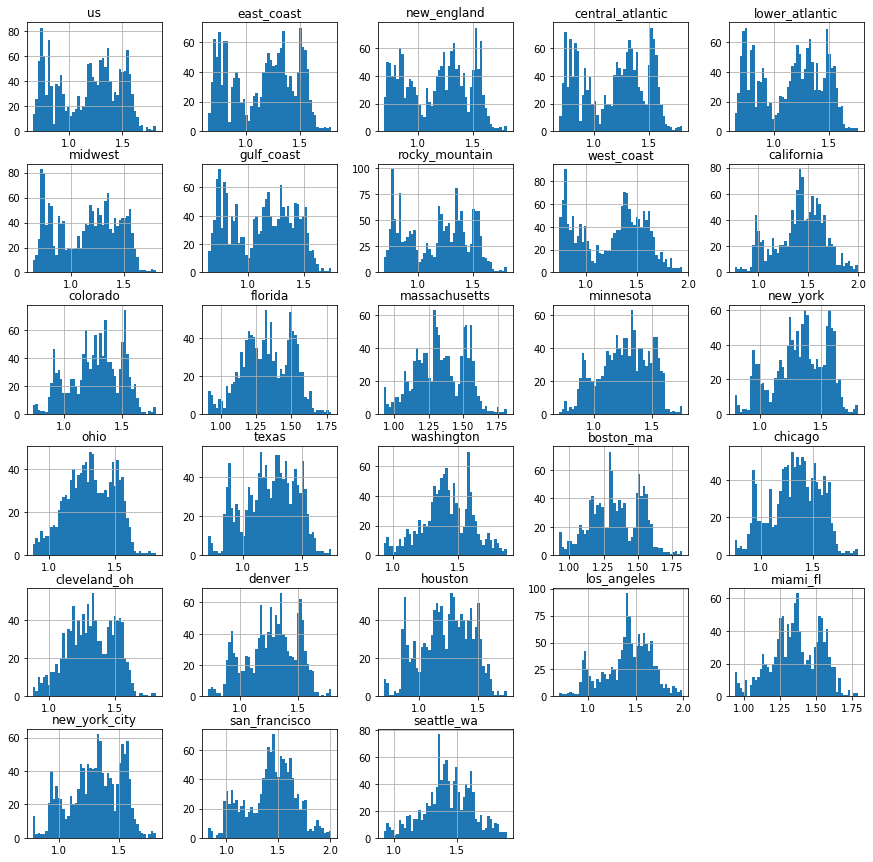

In [ ]:
np.log1p(dfn).hist(
    bins=50,
    figsize=(15,15)
);


Is possible to see 0 sales on regions where data is never collected, is just old data maybe i will filter this sales in future or i can apply weigth to this old examples such as SES.

The log transformation for target sales for more symmetric histograms and is possible to see very good histograms in some regions, probably the price change for lat long.

I have data from 1993-04-05 to 2024-05-06 in a weekly pattern and 1623 rows.


## 2.0. Time Series Analysis

In [ ]:
df2 = df1.copy()


### 2.1. Dataset Preprocessing


#### 2.1.1. Fillout Missing Values


Fillout with 0, because in this date i not selling nothing, but is quite dangerous to fillout with zeros because i can lose some patterns. The correct in some cases is a backcasting for this type of inconsistent series.

In [ ]:
df2.fillna(0, inplace=True)

In [ ]:
df2.head(5)

us 
 east_coast 
 new_england 
 central_atlantic 
 lower_atlantic 
 midwest 
 gulf_coast 
 rocky_mountain 
 west_coast 
 california 
 colorado 
 florida 
 massachusetts 
 minnesota 
 new_york 
 ohio 
 texas 
 washington 
 boston_ma 
 chicago 
 cleveland_oh 
 denver 
 houston 
 los_angeles 
 miami_fl 
 new_york_city 
 san_francisco 
 seattle_wa 
 date 
 
 
 
 
 0 
 1.068 
 1.040 
 1.068 
 1.068 
 1.023 
 1.061 
 1.064 
 1.093 
 1.152 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1993-04-05 
 
 
 1 
 1.079 
 1.047 
 1.073 
 1.072 
 1.032 
 1.077 
 1.071 
 1.118 
 1.154 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1993-04-12 
 
 
 2 
 1.079 
 1.054 
 1.074 
 1.077 
 1.040 
 1.067 
 1.081 
 1.120 
 1.155 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1993-04-19 
 
 
 3 
 1.086 
 1.059 
 1.076 
 1.080 
 1.046 
 1.078 
 1.081 
 1.169 
 1.157 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1993-04-26 
 
 
 4 
 1.086 
 1.062 
 1.080 
 1.084 
 1.050 
 1.073 
 1.084 
 1.161 
 1.161 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1993-05-03


#### 2.1.2. Stacking Dataframe

In [ ]:
df2_long = df2.melt(
    id_vars=["date"],
    var_name="region",
    value_name="price"
)

df2_long.columns = ["date", "region", "price"]


Long dataframe for machine learning.

The date columns, id of time series and the target variable, classic design for table in time series.

In [ ]:
df2_long.head()

date 
 region 
 price 
 
 
 
 
 0 
 1993-04-05 
 us 
 1.068 
 
 
 1 
 1993-04-12 
 us 
 1.079 
 
 
 2 
 1993-04-19 
 us 
 1.079 
 
 
 3 
 1993-04-26 
 us 
 1.086 
 
 
 4 
 1993-05-03 
 us 
 1.086


### 2.2. Time Plots

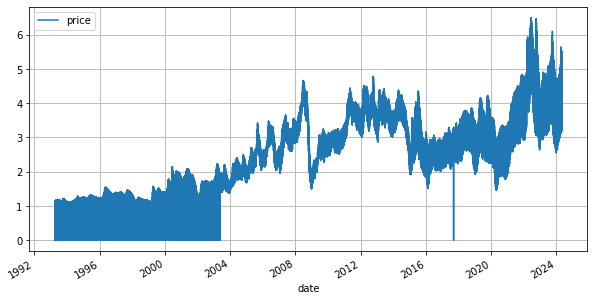

In [ ]:
df2_long.plot(
    x="date",
    y="price",
    figsize=(10,5),
    grid=2
);


### 2.3. Statistical Checkout

In [ ]:
dff = df2_long.copy()
dff.set_index("date", inplace=True)

dff2 = df2_long[df2_long["date"] >= "2019-01-01"].copy()
dff2.set_index("date", inplace=True)


I will apply some resume of data to check the variability of patterns, such as acf and diff.

Is possible to apply some other metrics, such as:

1. Coefficient of Hurst: Hurst coefficient of a time series which is a measure of “long memory”. A series with long memory will have significant autocorrelations for many lags.
2. Feature Spectral: Compute the (Shannon) spectral entropy of a time series, which is a measure of how easy the series is to forecast. A series which has strong trend and seasonality (and so is easy to forecast) will have entropy close to 0. A series that is very noisy (and so is difficult to forecast) will have entropy close to 1.
3. Box Pierce, Ljung & KPSS: Compute the testing of time series is white noise (stationary) or not (visually i will see the series is not stationary, filtering years of data the series is not stationary too).
4. Tiled Features: Gives the variances, mean, and other statistics of "pieces" of data over time.
5. Guerrero: Better lambda for Box Cox transformation. 

I selected some metrics to see between all data and >= 2019.

1. Mean Differences Squares: Is very basic, if i see a very big difference, the series change drastically. 
2. Mean Shift for 12 weeks: Shifting the series in 12 lags to see any pattern in 12 likes shift.
3. Mean Shift for 52 weeks: Shifting the series in 52 lags to see any pattern in 52 likes shift.
4. Mean Autocorrelation of n Lag: Mean of first autocorrelation in lag 1, this measures the average correlation between each observation in the time series and the observation in the previous time period (lag n).
  - A high autocorrelation at lag 1 suggests that consecutive observations are strongly related to each other, indicating persistence or trend in the data.
  - A high autocorrelated at lag 51, 52, 53 suggests that consecutive observation are strongly related to same observation one year ago (weekly data).

In [ ]:
df2_long[df2_long["date"] >= "2019-01-01"].iloc[:, 1:].groupby("region").agg(
    m_o_price=("price", lambda x: np.mean(x)),
    std_o_price=("price", lambda x: np.std(x)),

    m_diff=("price", lambda x: np.mean(x.diff() ** 2)),
    m12_shift=("price", lambda x: np.mean(x.shift(12))),
    m52_shift=("price", lambda x: np.mean(x.shift(52))),

    acf1=("price", lambda x: acf(x, nlags=1)[-1]),
    acf26=("price", lambda x: acf(x, nlags=26)[-1]),
    acf51=("price", lambda x: acf(x, nlags=51)[-1]),
    acf52=("price", lambda x: acf(x, nlags=52)[-1]),
    acf53=("price", lambda x: acf(x, nlags=53)[-1]),

    acf51_sq=("price", lambda x: np.sum(acf(x, nlags=51)[1:] ** 2)),
    acf52_sq=("price", lambda x: np.sum(acf(x, nlags=52)[1:] ** 2)),
    acf53_sq=("price", lambda x: np.sum(acf(x, nlags=53)[1:] ** 2)),

    diff1_acf1=("price", lambda x: acf(x.diff().dropna(), nlags=1)[-1]),
    diff1_acf52=("price", lambda x: np.sum(acf(x.diff().dropna(), nlags=52)[1:] ** 2)),
    
    diff2_acf1=("price", lambda x: acf(x.diff().dropna().diff().dropna(), nlags=1)[-1]),
    diff2_acf52=("price", lambda x: np.sum(acf(x.diff().dropna().diff().dropna(), nlags=52)[1:] ** 2)),
).sort_values("m_o_price", ascending=True)

m_o_price 
 std_o_price 
 m_diff 
 m12_shift 
 m52_shift 
 acf1 
 acf26 
 acf51 
 acf52 
 acf53 
 acf51_sq 
 acf52_sq 
 acf53_sq 
 diff1_acf1 
 diff1_acf52 
 diff2_acf1 
 diff2_acf52 
 
 
 region 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 texas 
 2.757082 
 0.647485 
 0.007163 
 2.738217 
 2.675132 
 0.987054 
 0.530736 
 0.319043 
 0.311935 
 0.304422 
 19.020265 
 19.117569 
 19.210241 
 0.273060 
 0.392319 
 -0.497482 
 0.500393 
 
 
 houston 
 2.758047 
 0.639102 
 0.005620 
 2.740228 
 2.680493 
 0.989479 
 0.518682 
 0.300887 
 0.293606 
 0.285935 
 18.580564 
 18.666768 
 18.748527 
 0.467429 
 0.622091 
 -0.321647 
 0.315417 
 
 
 gulf_coast 
 2.781452 
 0.649289 
 0.005948 
 2.763487 
 2.700211 
 0.988782 
 0.559550 
 0.326915 
 0.319043 
 0.310942 
 20.086232 
 20.188021 
 20.284705 
 0.385918 
 0.498792 
 -0.401689 
 0.411382 
 
 
 lower_atlantic 
 2.947878 
 0.645944 
 0.005269 
 2.926655 
 2.856524 
 0.989341 
 0.606028 
 0.351793 
 0.343038 
 0.334634 
 21.969265 
 22.086941 
 22.198920 
 0.444033 
 0.466126 
 -0.266906 
 0.281415 
 
 
 minnesota 
 2.952100 
 0.683290 
 0.005565 
 2.937682 
 2.857225 
 0.990704 
 0.593410 
 0.370231 
 0.361178 
 0.352527 
 21.595611 
 21.726061 
 21.850337 
 0.507253 
 0.698431 
 -0.252112 
 0.239168 
 
 
 ohio 
 2.981885 
 0.681227 
 0.017507 
 2.960019 
 2.896070 
 0.976670 
 0.564776 
 0.356917 
 0.348421 
 0.337970 
 19.927194 
 20.048592 
 20.162816 
 -0.019288 
 0.202254 
 -0.560058 
 0.544523 
 
 
 midwest 
 2.994688 
 0.690160 
 0.006441 
 2.975674 
 2.905396 
 0.989105 
 0.572763 
 0.359755 
 0.350997 
 0.341965 
 20.732113 
 20.855312 
 20.972252 
 0.506657 
 0.726572 
 -0.270565 
 0.252547 
 
 
 florida 
 3.001405 
 0.659427 
 0.008752 
 2.979333 
 2.907093 
 0.985509 
 0.607311 
 0.359600 
 0.350593 
 0.341757 
 21.832949 
 21.955864 
 22.072661 
 0.107548 
 0.158188 
 -0.472968 
 0.420183 
 
 
 cleveland_oh 
 3.019204 
 0.677565 
 0.014521 
 2.998041 
 2.937736 
 0.979306 
 0.574020 
 0.339692 
 0.331240 
 0.322320 
 20.016038 
 20.125758 
 20.229648 
 0.068358 
 0.257269 
 -0.551417 
 0.558143 
 
 
 east_coast 
 3.065448 
 0.661538 
 0.004300 
 3.046719 
 2.972207 
 0.991243 
 0.625227 
 0.352992 
 0.344585 
 0.336328 
 22.810375 
 22.929114 
 23.042230 
 0.521151 
 0.592169 
 -0.201206 
 0.314323 
 
 
 miami_fl 
 3.072548 
 0.670480 
 0.006654 
 3.050086 
 2.972687 
 0.988743 
 0.616425 
 0.367358 
 0.357882 
 0.348608 
 22.419640 
 22.547720 
 22.669248 
 0.216149 
 0.226256 
 -0.445613 
 0.363364 
 
 
 new_england 
 3.132781 
 0.702614 
 0.004391 
 3.117854 
 3.034837 
 0.992593 
 0.625210 
 0.339709 
 0.332172 
 0.324264 
 22.678807 
 22.789145 
 22.894293 
 0.559193 
 0.715635 
 -0.234134 
 0.335909 
 
 
 massachusetts 
 3.138735 
 0.705633 
 0.004378 
 3.124199 
 3.040427 
 0.993010 
 0.620438 
 0.331480 
 0.324251 
 0.316496 
 22.547671 
 22.652810 
 22.752979 
 0.534468 
 0.700998 
 -0.224540 
 0.432869 
 
 
 denver 
 3.141229 
 0.688950 
 0.008751 
 3.141461 
 3.084687 
 0.987662 
 0.471509 
 0.341150 
 0.336087 
 0.330737 
 16.356751 
 16.469706 
 16.579092 
 0.527720 
 1.136724 
 -0.306064 
 0.399368 
 
 
 colorado 
 3.153742 
 0.687333 
 0.008151 
 3.153933 
 3.095916 
 0.988367 
 0.486213 
 0.335214 
 0.330287 
 0.325081 
 16.811318 
 16.920408 
 17.026085 
 0.529057 
 1.167129 
 -0.329044 
 0.427144 
 
 
 boston_ma 
 3.159061 
 0.713535 
 0.004209 
 3.144948 
 3.059674 
 0.993298 
 0.619250 
 0.331311 
 0.324066 
 0.316279 
 22.619034 
 22.724053 
 22.824085 
 0.542717 
 0.721225 
 -0.234679 
 0.383428 
 
 
 us 
 3.170373 
 0.693144 
 0.004493 
 3.150506 
 3.071401 
 0.991377 
 0.610387 
 0.363160 
 0.353751 
 0.344125 
 22.213874 
 22.339014 
 22.457436 
 0.603591 
 0.862511 
 -0.163578 
 0.271703 
 
 
 new_york_city 
 3.173910 
 0.680054 
 0.004929 
 3.159221 
 3.081441 
 0.991551 
 0.614344 
 0.333017 
 0.325012 
 0.316813 
 22.183755 
 22.289387 
 22.389758 
 0.500957 
 0.593042 
 -0.244503 
 0.335486 
 
 
 new_york 
 3.201903 
 0.680820 
 0.00407

In [ ]:
dff2[dff2["region"] == "ohio"].tail(20)

region 
 price 
 
 
 date 
 
 
 
 
 
 
 2023-12-25 
 ohio 
 2.984 
 
 
 2024-01-01 
 ohio 
 2.856 
 
 
 2024-01-08 
 ohio 
 2.694 
 
 
 2024-01-15 
 ohio 
 2.948 
 
 
 2024-01-22 
 ohio 
 3.188 
 
 
 2024-01-29 
 ohio 
 3.063 
 
 
 2024-02-05 
 ohio 
 3.121 
 
 
 2024-02-12 
 ohio 
 3.220 
 
 
 2024-02-19 
 ohio 
 3.407 
 
 
 2024-02-26 
 ohio 
 3.257 
 
 
 2024-03-04 
 ohio 
 3.515 
 
 
 2024-03-11 
 ohio 
 3.437 
 
 
 2024-03-18 
 ohio 
 3.298 
 
 
 2024-03-25 
 ohio 
 3.500 
 
 
 2024-04-01 
 ohio 
 3.405 
 
 
 2024-04-08 
 ohio 
 3.602 
 
 
 2024-04-15 
 ohio 
 3.475 
 
 
 2024-04-22 
 ohio 
 3.729 
 
 
 2024-04-29 
 ohio 
 3.571 
 
 
 2024-05-06 
 ohio 
 3.425

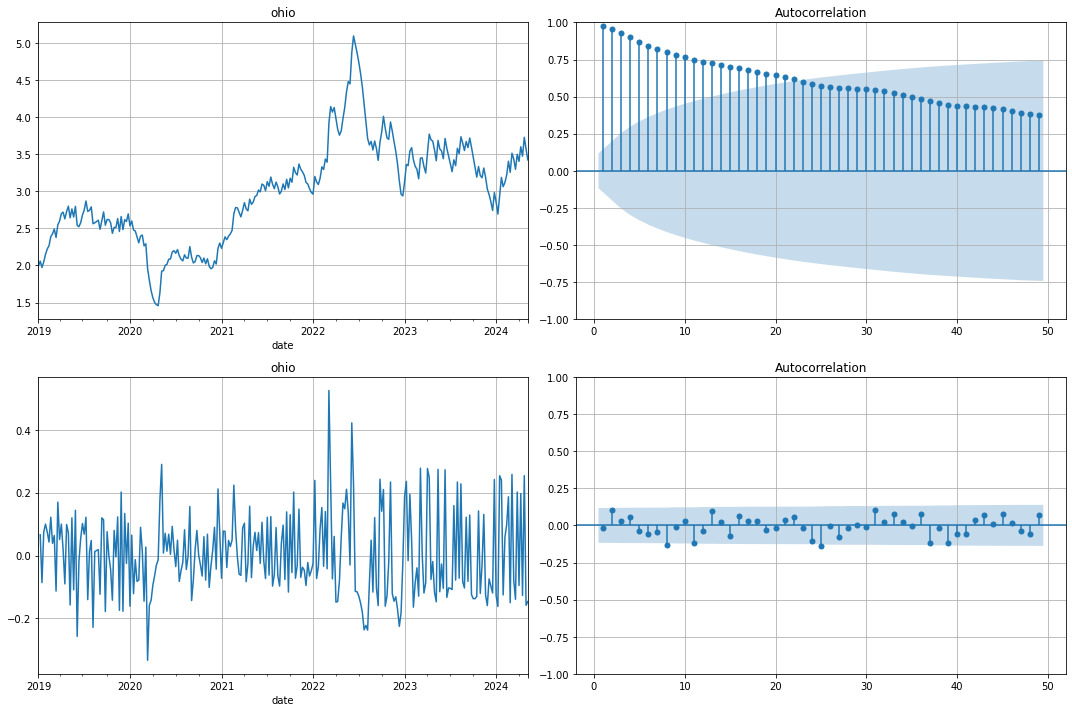

In [ ]:
plot_diff_acf(dff2, "ohio")

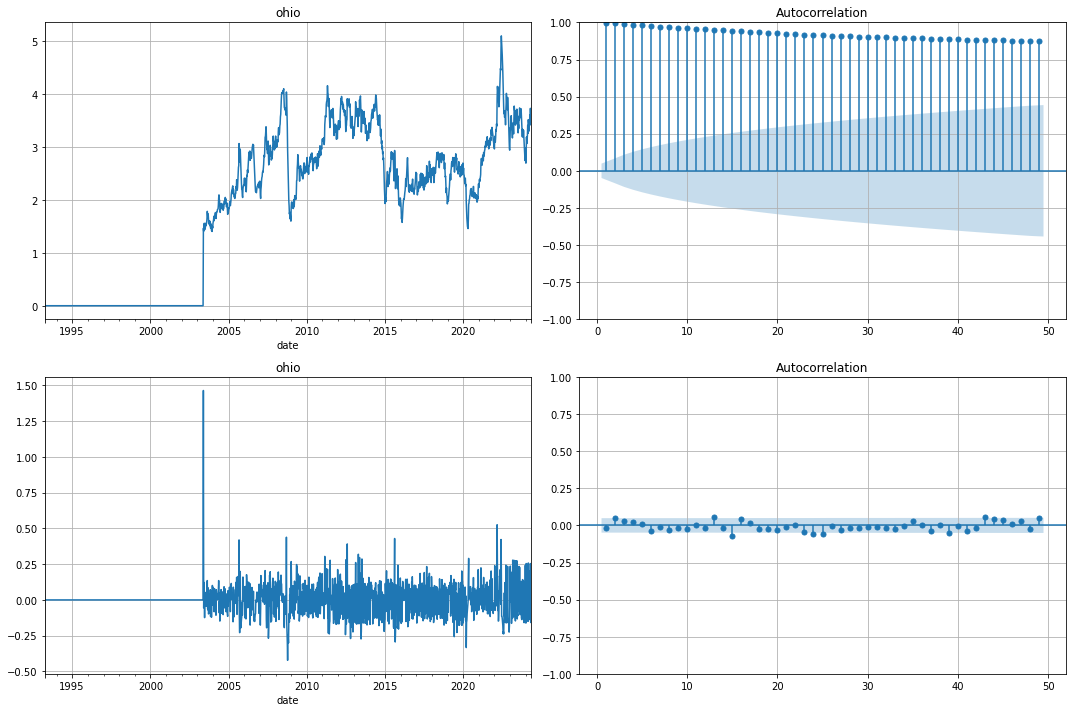

In [ ]:
plot_diff_acf(dff, "ohio")

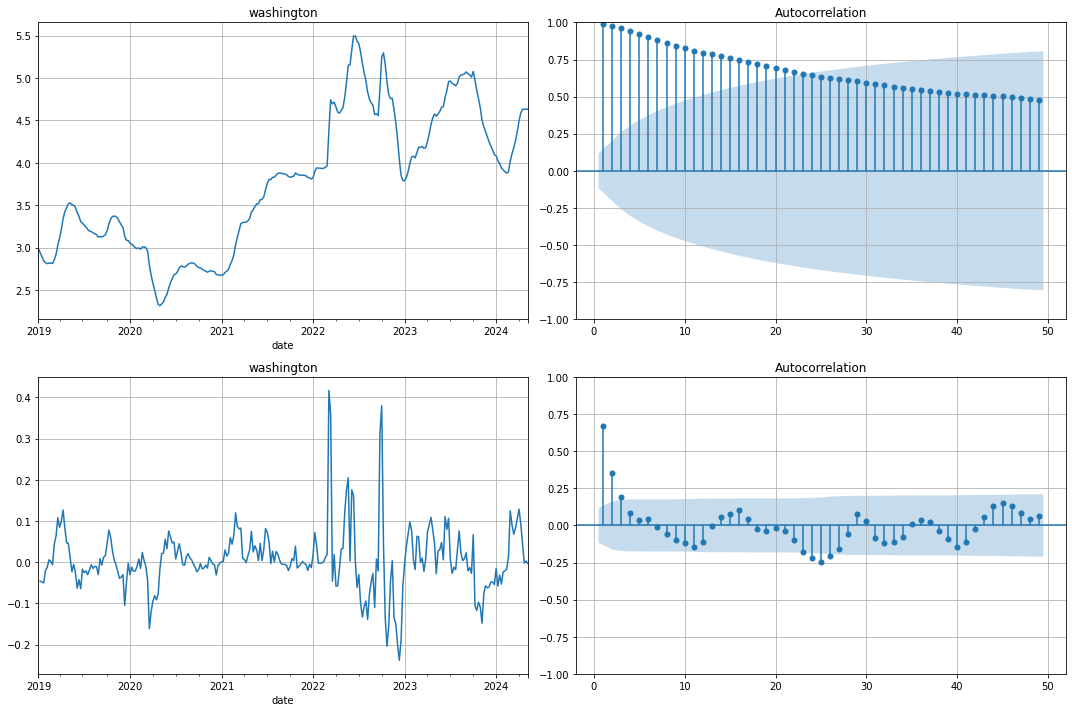

In [ ]:
plot_diff_acf(dff2, "washington")

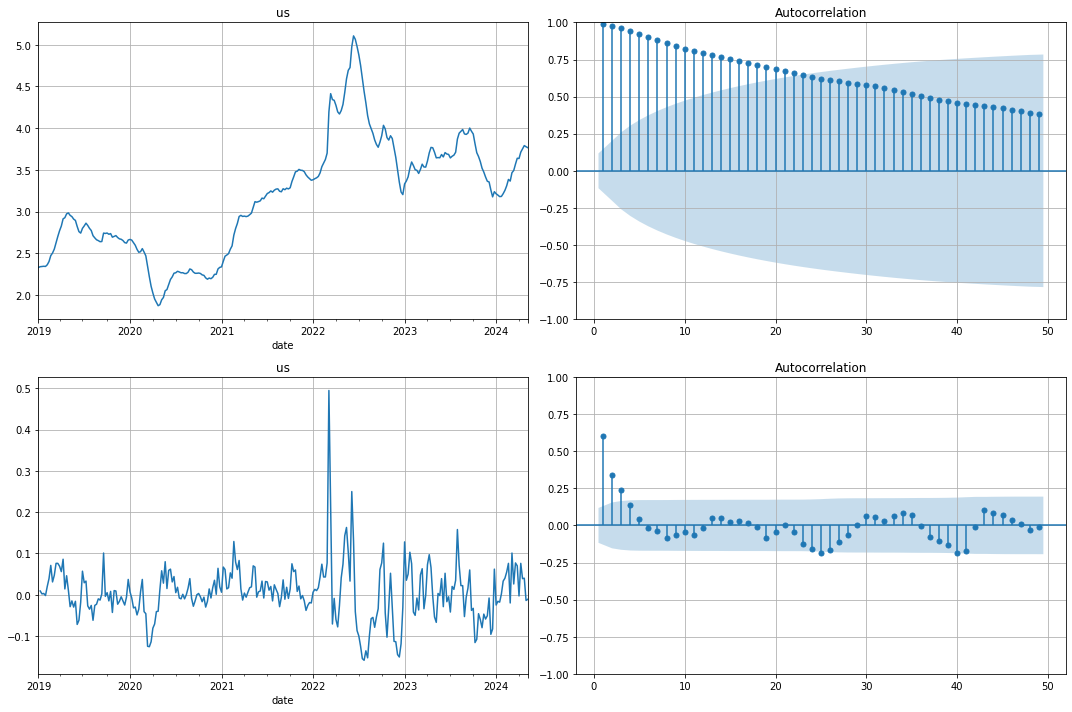

In [ ]:
plot_diff_acf(dff2, "us")

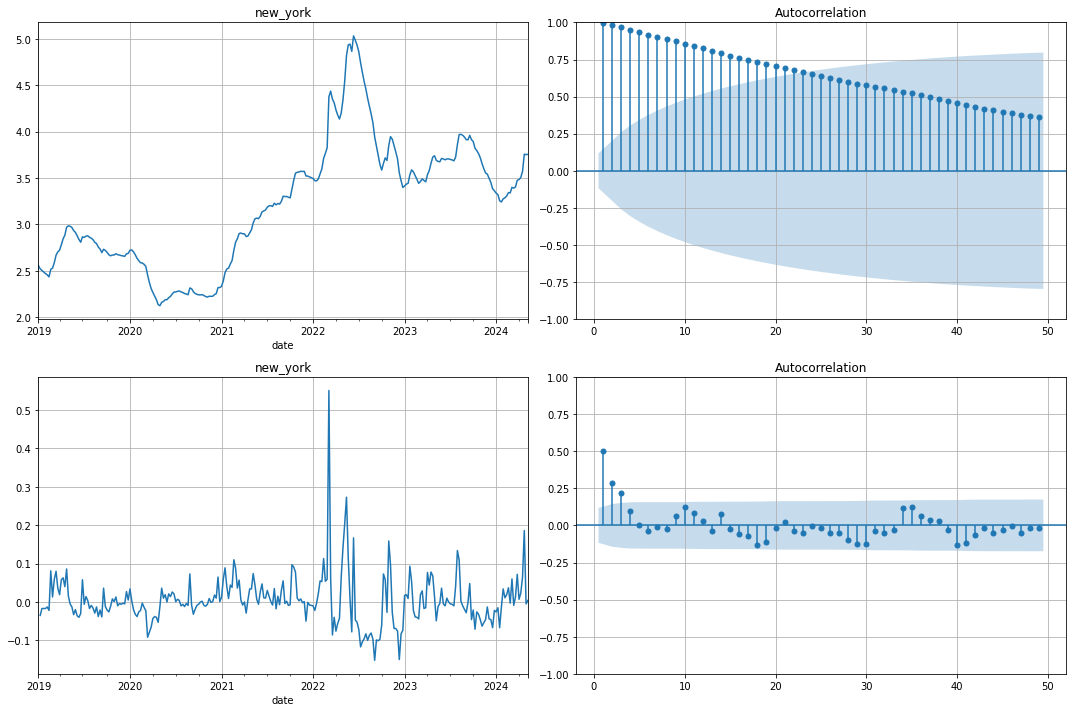

In [ ]:
plot_diff_acf(dff2, "new_york")

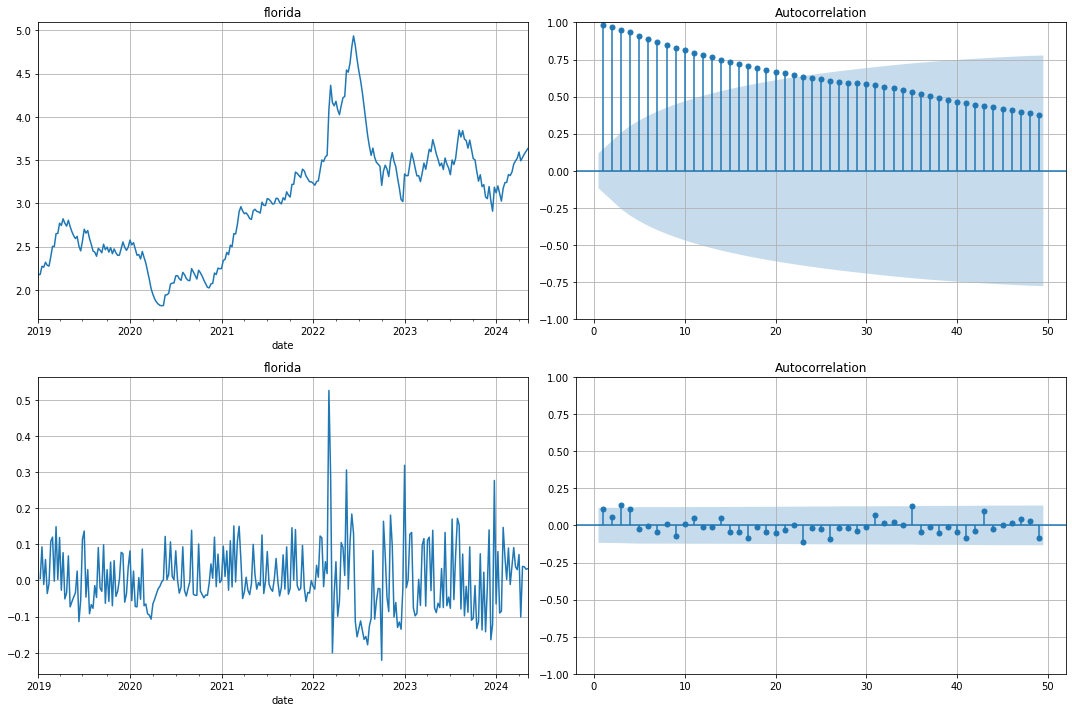

In [ ]:
plot_diff_acf(dff2, "florida")


## 3.0. Feature Engineering


### 3.1. Future Datafarme for Feature Engineering


For feature engineering is necessary a long dataframe with (date, key, y) and **consistency weeks**, we can do a resampling for monthly data or work with weekly data too.

I will create the future dataframe for compute all necessary features just one time for train, test, valid, cv and future forecasting, because is necessary all available features for future forcasting and for CV time blocks.

The business problem is about forecasting the next 4 months of gas price, if today is 2021-01-01, the forecast of gas price is for today up to 2021-04-01, for this study case i will select series >= 2020 for this development cycle, 2020 fully for train and in 2021 and a forecast interval of 4 months for CV and one month with gap.

In [ ]:
df3 = df2_long.copy()
df3 = df3.set_index("date").groupby("region").resample("W").sum().reset_index()
df3 = df3.sort_values(["date", "region"]).reset_index(drop=2)

df3["future"] = False

In [ ]:
dt_range = pd.date_range(
    df3["date"].max(),
    df3["date"].max() + pd.DateOffset(months=4),
    freq="W"
)[1:].to_list()

dff = pd.DataFrame([{"region": region, "date": dt_range} for region in df3.region.unique()]).explode("date").sort_values(["date", "region"]).reset_index(drop=2)
dff["price"] = np.nan
dff["future"] = True

df3 = pd.concat([df3, dff]).reset_index(drop=True)
f = (df3["future"] == True)

In [ ]:
df3

region 
 date 
 price 
 future 
 
 
 
 
 0 
 boston_ma 
 1993-04-11 
 0.000 
 False 
 
 
 1 
 california 
 1993-04-11 
 0.000 
 False 
 
 
 2 
 central_atlantic 
 1993-04-11 
 1.068 
 False 
 
 
 3 
 chicago 
 1993-04-11 
 0.000 
 False 
 
 
 4 
 cleveland_oh 
 1993-04-11 
 0.000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 45915 
 seattle_wa 
 2024-09-08 
 NaN 
 True 
 
 
 45916 
 texas 
 2024-09-08 
 NaN 
 True 
 
 
 45917 
 us 
 2024-09-08 
 NaN 
 True 
 
 
 45918 
 washington 
 2024-09-08 
 NaN 
 True 
 
 
 45919 
 west_coast 
 2024-09-08 
 NaN 
 True 
 
 
 
 45920 rows × 4 columns


In time series, we cannot choose random samples for cross-validation because time order is important, it makes sense to use previous data to predict the next *n* samples in a given interval.

The business problem requires an accurate gas price forecast for 4 months. Make sense to slide the price prediction window in a range of 4 months (forecast interval) with a extra "gap" of one month, this technique is called sliding prequential with gap, basically 4 sliding months and one month off.

Why is it important?

I need all my *feature engineering features* available for forecasting at all intervals (future intervals). If I get NaN, something happened and I need to fix it i cannot have nan variables to future.

In [ ]:
dff = df3[df3["region"] == "ohio"]
dff = dff[dff["date"] >= "2020-01-01"]
dff = dff[~f]

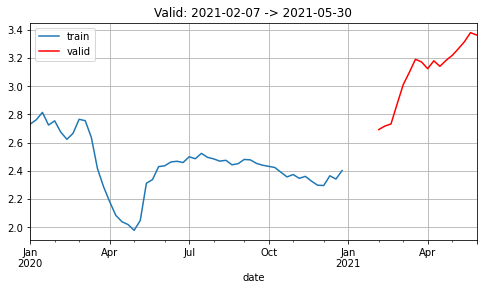

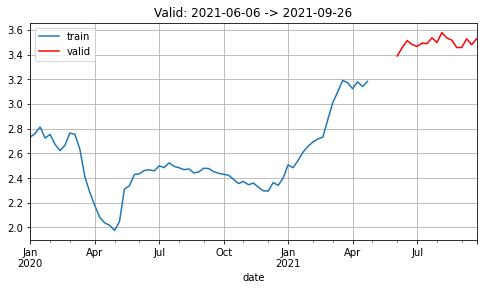

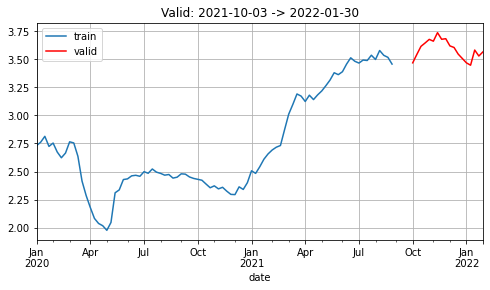

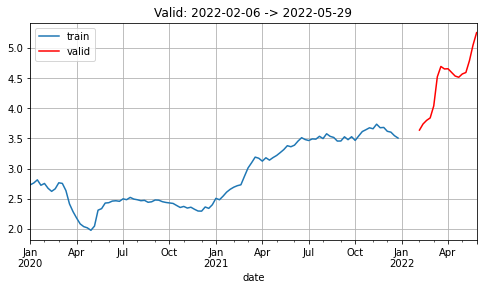

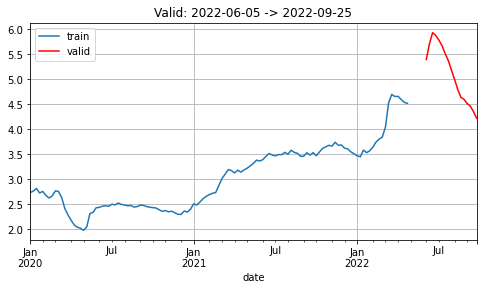

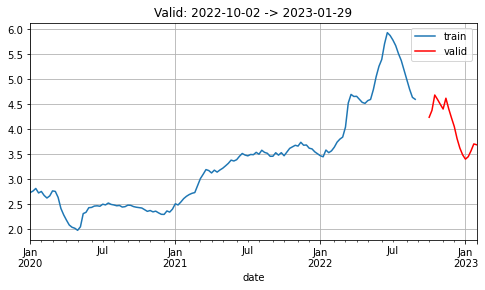

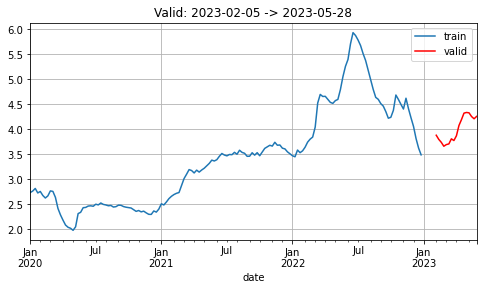

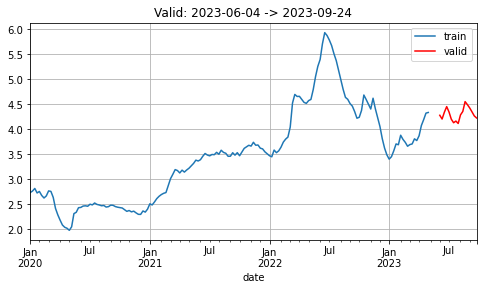

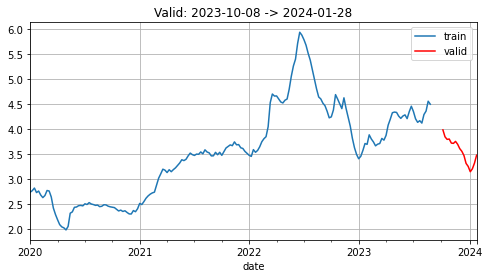

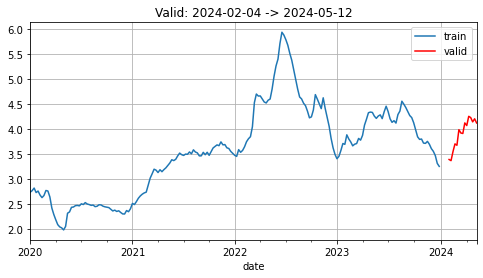

In [ ]:
# Starting Validation date & gap of one month
cutoff_date = datetime(2021, 1, 1)
gap_months = 1

while df3[~f]["date"].max() >= cutoff_date:
    # Training and Valid with one month gap pandas spliting
    start_cutoff_date_gap = (cutoff_date + pd.DateOffset(months=gap_months)).strftime("%Y-%m") + "-01"
    end_cutoff_end_date_gap = (cutoff_date + pd.DateOffset(months=gap_months + 4)).strftime("%Y-%m") + "-01"

    df_train = dff[dff["date"] < cutoff_date.strftime("%Y-%m-%d")]
    df_valid = dff[(dff["date"] > start_cutoff_date_gap) & (dff["date"] < end_cutoff_end_date_gap)]

    # if do not have data, than break
    if df_valid.empty: break

    ax = df_train.plot(x="date", y="price", label="train", figsize=(8, 4))
    df_valid.plot(x="date", y="price", color="r", ax=ax, label="valid", grid=2)
    ax.set_title(f"Valid: {df_valid['date'].min().strftime('%Y-%m-%d')} -> {df_valid['date'].max().strftime('%Y-%m-%d')}");

    cutoff_date += pd.DateOffset(months=4)


### 3.2. Mind Map & Hypothesis List


![mind_map](https://raw.githubusercontent.com/xGabrielR/Gas-Price-Forecast/main/imgs/mind_map.png)


1. The total price of gas increased more then 50% compared to the previous year.
2. The total price of gas increase more than 10% in last two quarters on year.
3. The region Ohio have gas price 2x more expensive than other regions.
4. The last days of months, the gas price have a increase of 5x compared to days of start of month. 
5. Texas have the lowest gas price based on all other countries (plot in map). 


### 3.3. Feature Creation


[x] 1. Date Derivative features;

[x] 2. Time Series Features (Lag, Diff, Acf, Sums...);

[ ] 3. Decomposition Features (Season, Trend, MA...).

[x] 4. Lat Long Features (Rotations, inspections, maps...).

[ ] 5. Other featured derivated from mind map to help price forecasting.

Exists a lot of features to compute in time series, but i will start with more simple fatures.
All features is stored in a Feature Store.


#### 3.3.1. Date Features

In [ ]:
df3["day"] = df3.date.dt.day
df3["year"] = df3.date.dt.year
df3["month"] = df3.date.dt.month
df3["quarter"] = df3.date.dt.quarter
df3["week"] = df3.date.dt.isocalendar()["week"]


#### 3.3.2. Time Series Features


For lag features, i will forecast the next 4 months, is necessary 4 months lag and greather for creating lag features for forecasting interval not getting NaN.

In [ ]:
df3["lag_4_months"] = df3.groupby("region")["price"].shift(17)
df3["lag_5_months"] = df3.groupby("region")["price"].shift(22)
df3["lag_12_months_plus"] = df3.groupby("region")["price"].shift(53)
df3["lag_12_months"] = df3.groupby("region")["price"].shift(52)
df3["lag_12_months_minus"] = df3.groupby("region")["price"].shift(51)

df3["diff_4_months"] = df3.groupby("region")["price"].shift(17).diff(17)
df3["diff_5_months"] = df3.groupby("region")["price"].shift(22).diff(22)
df3["diff_12_months_plus"] = df3.groupby("region")["price"].shift(53).diff(53)
df3["diff_12_months"] = df3.groupby("region")["price"].shift(52).diff(52)
df3["diff_12_months_minus"] = df3.groupby("region")["price"].shift(51).diff(51)


#### 3.3.3. Lat Long Features

In [ ]:
df3["latitude"] = np.nan
df3["longitude"] = np.nan

In [ ]:
for region in df3.region.unique()[20:]:
    if region == "lower_atlantic":
        query = "south carolina us"
    elif region == "ohio":
        query = "ohio"
    else:
        query = f"us - {region}"

    geo = agent.geocode(query)
    df3.loc[df3["region"] == region, "latitude"] = geo.latitude
    df3.loc[df3["region"] == region, "longitude"] = geo.longitude

    sleep(5)

In [ ]:
spark.createDataFrame(df3).coalesce(1).write.format("delta").save("/mnt/delta/gas_price_features")

In [ ]:
# Save Features into to Feature Storage
fs = feature_store.FeatureStoreClient()

df_spark = spark.createDataFrame(df3)

fs.create_table(
    name="gas_price_raw_features",
    description="Raw Gas Price Forecast Features",
    df=df_spark,
    schema=df_spark.schema,
    primary_keys=["date", "region"]
)


## 4.0. Data Filtering

In [ ]:
df4 = df3.copy()

df4 = df4[df4["date"] >= "2020-01-01"]


## 5.0. Exploratory Data Analysis


### 5.1. Univariate Analysis

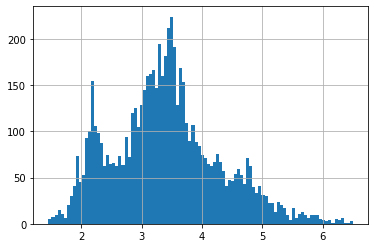

In [ ]:
df4["price"].hist(bins=100);

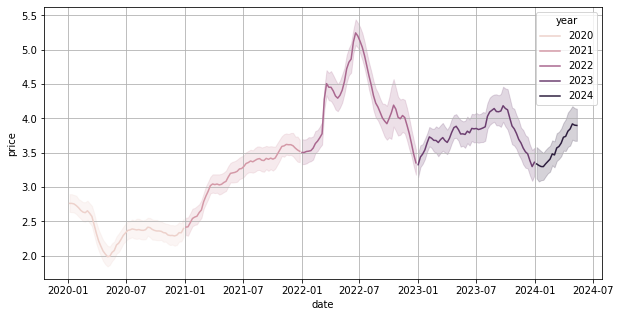

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df4, x="date", y="price", hue="year", ax=ax)
ax.grid(2);


### 5.2. Bivariate Analysis


#### 5.2.1. Seasonal Plots

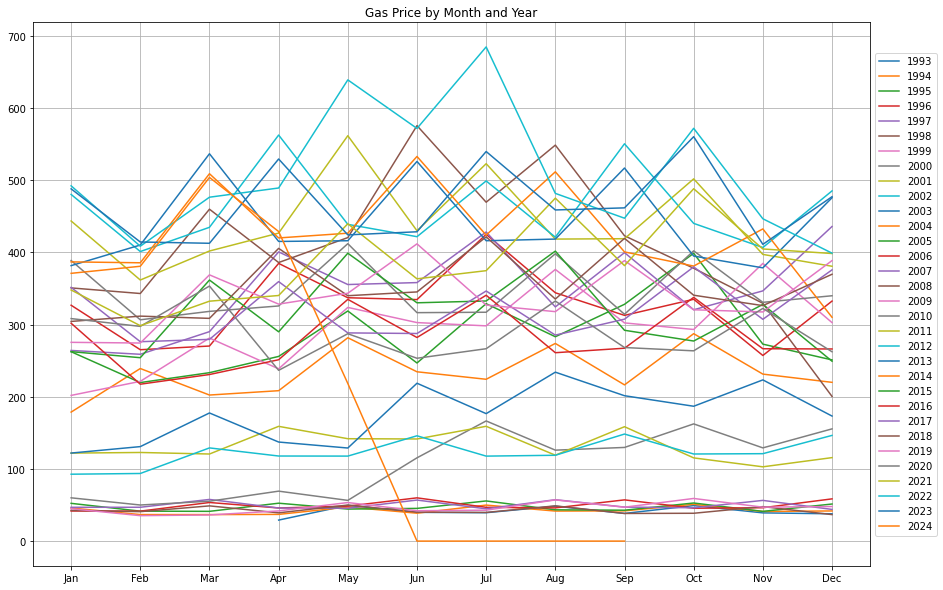

In [ ]:
plot_seasons_year_month(df3)

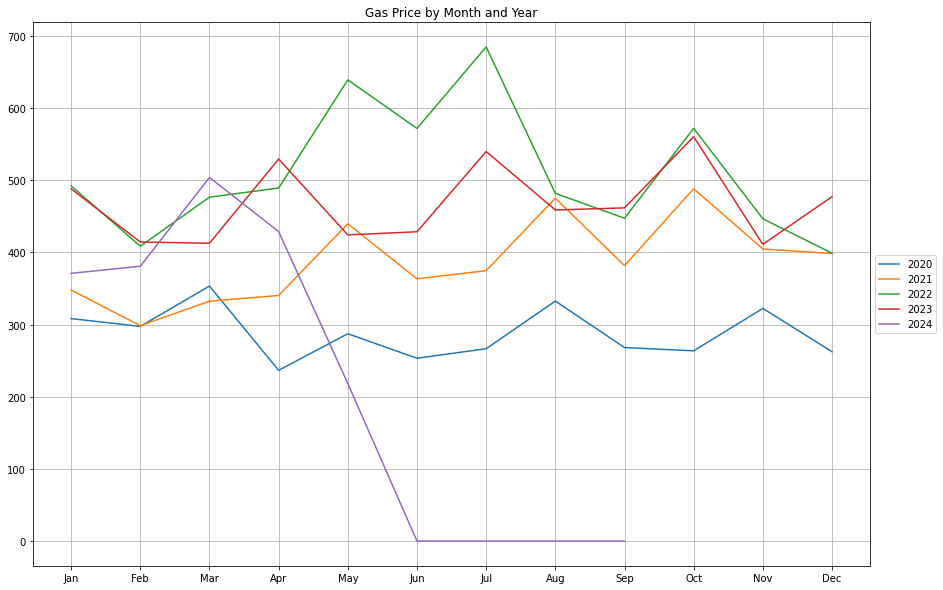

In [ ]:
plot_seasons_year_month(df4)

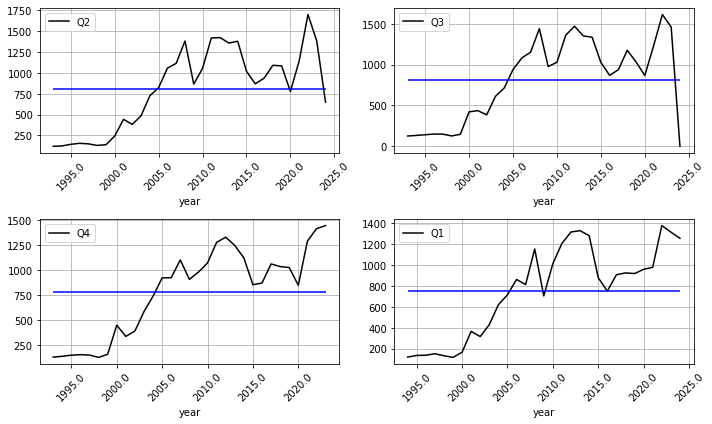

In [ ]:
plot_seasons_quarter_month(df3)

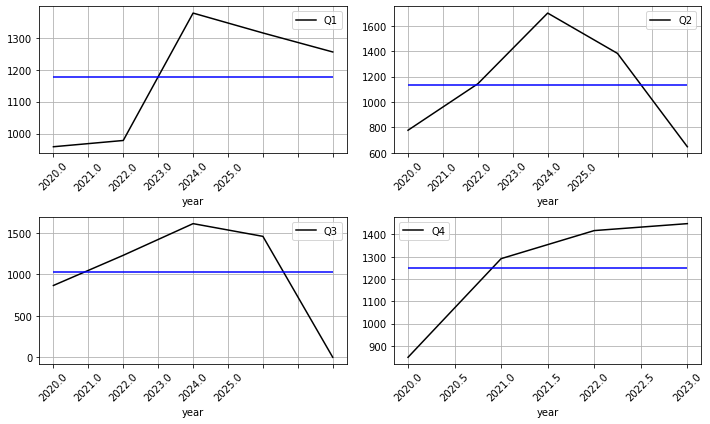

In [ ]:
plot_seasons_quarter_month(df4)


#### 5.2.2. Hypothesis Plots


##### **The total price of gas increased more then 50% compared to the previous year.**

False

price 
 
 
 year 
 
 
 
 
 
 2022 
 4.195146 
 
 
 2023 
 3.777522 
 
 
 2024 
 3.576695 
 
 
 2021 
 3.189953 
 
 
 2020 
 2.370723

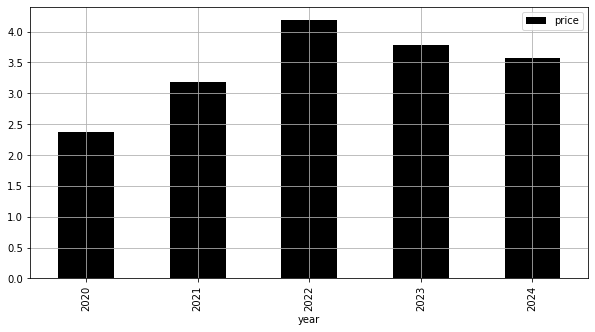

In [ ]:
mean_prices = df4[["price", "year"]].groupby("year").mean()

mean_prices.plot(
  kind="bar",
  color="k",
  figsize=(10,5),
  grid=2
);

mean_prices.sort_values(by="price", ascending=False).head()


##### **The total price of gas increase more than 10% in last two quarters on year.**

False

price 
 
 
 quarter 
 
 
 
 
 
 3 
 2.272807 
 
 
 2 
 2.253568 
 
 
 4 
 2.120300 
 
 
 1 
 2.084511

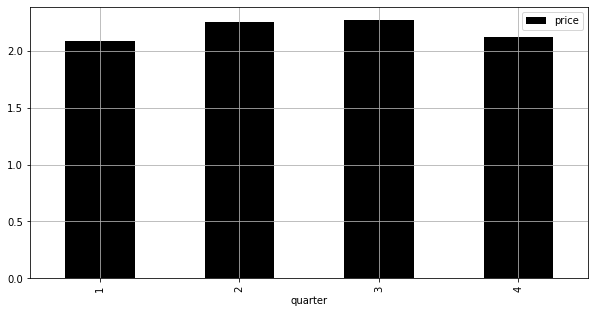

In [ ]:
mean_prices = df3[["price", "quarter"]].groupby("quarter").mean()

mean_prices.plot(
  kind="bar",
  color="k",
  figsize=(10,5),
  grid=2
);

mean_prices.sort_values(by="price", ascending=False).head()


##### **The region Ohio have gas price 2x more expensive than other regions.**

False

           region     price
22  san_francisco  1029.525
1      california  1005.848
11    los_angeles  1002.867
27     west_coast   941.271
23     seattle_wa   928.695


region 
 price 
 
 
 
 
 16 
 minnesota 
 695.852 
 
 
 12 
 lower_atlantic 
 695.589 
 
 
 9 
 gulf_coast 
 656.029 
 
 
 24 
 texas 
 649.009 
 
 
 10 
 houston 
 647.829

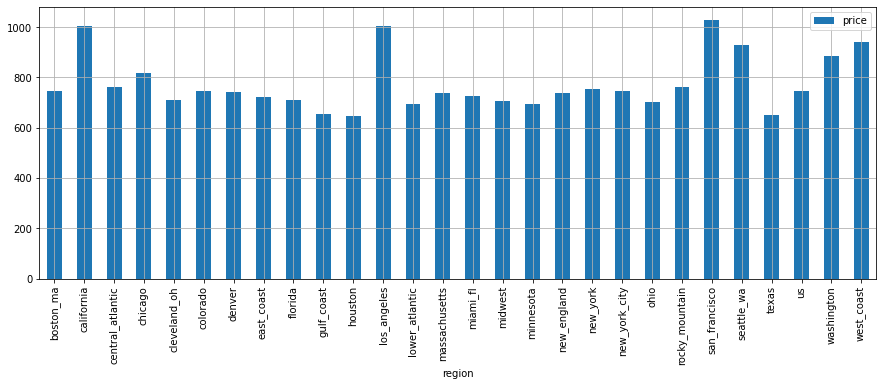

In [ ]:
df3p = df4[["region", "price"]].groupby("region").sum().reset_index()

df3p.plot(
    kind="bar",
    x="region",
    y="price",
    figsize=(15,5),
    grid=2
)

plt.xticks(rotation=90);

print(df3p.sort_values(by="price", ascending=False).head(5))

df3p.sort_values(by="price", ascending=False).tail(5)

              region     price
27        west_coast  4367.035
22     san_francisco  4111.461
11       los_angeles  4054.497
1         california  4044.943
2   central_atlantic  3904.667


region 
 price 
 
 
 
 
 24 
 texas 
 3118.408 
 
 
 10 
 houston 
 3106.966 
 
 
 8 
 florida 
 3098.240 
 
 
 4 
 cleveland_oh 
 3065.558 
 
 
 20 
 ohio 
 3041.248

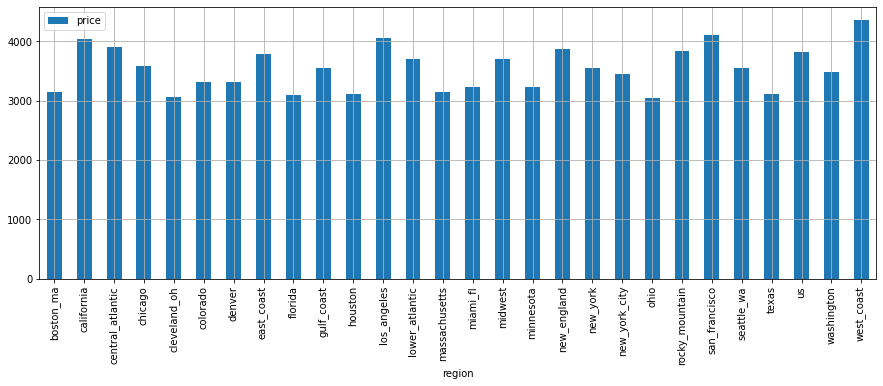

In [ ]:
df3p = df3[["region", "price"]].groupby("region").sum().reset_index()

df3p.plot(
    kind="bar",
    x="region",
    y="price",
    figsize=(15,5),
    grid=2
)

plt.xticks(rotation=90);

print(df3p.sort_values(by="price", ascending=False).head(5))

df3p.sort_values(by="price", ascending=False).tail(5)


##### **The last days of months, the gas price have a increase of 5x compared to days of start of month.**

False

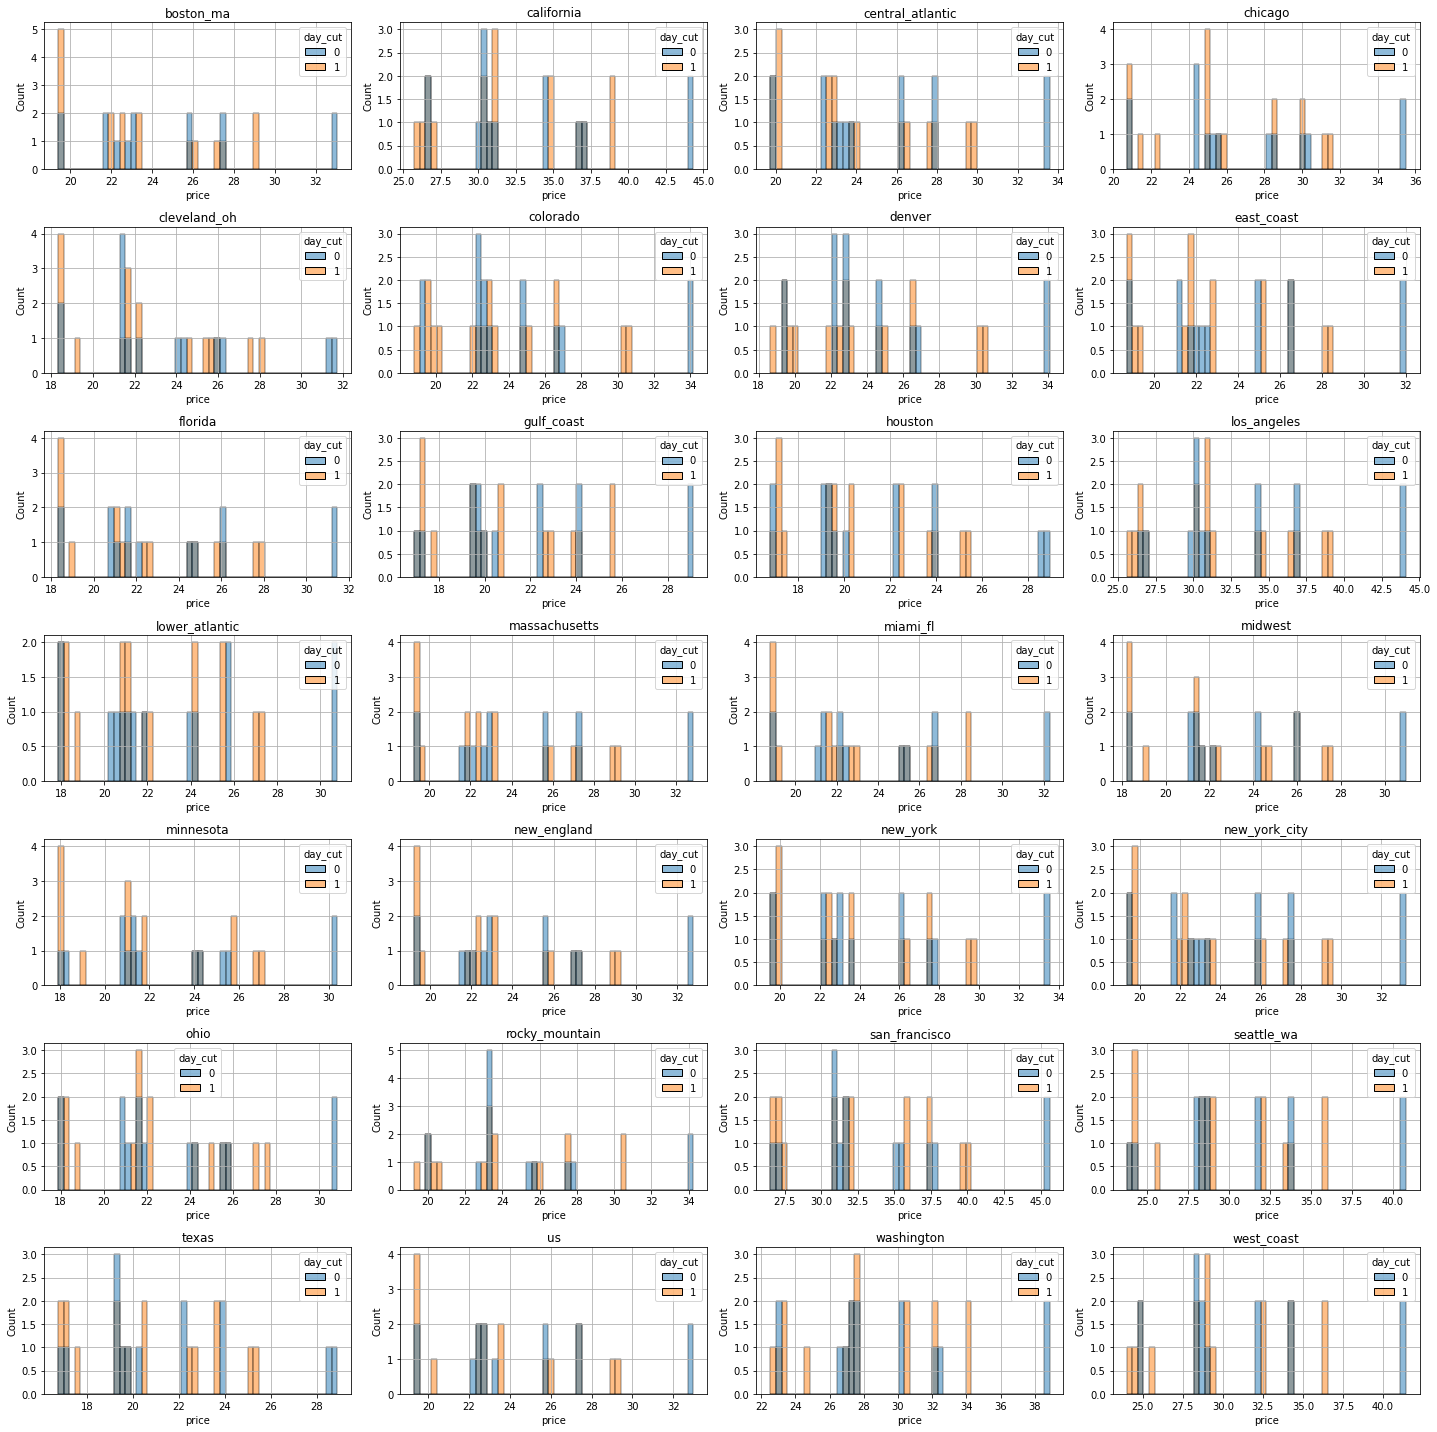

In [ ]:
df3p = df4[["region", "day", "price"]].groupby(["day", "region"]).sum().reset_index()
df3p["day_cut"] = df3p["day"].apply(lambda x: 1 if x >= 15 else 0)

fig, ax = plt.subplots(7, 4, figsize=(20,20))
ax = ax.flatten()

for region, axi in zip(df3p.region.unique(), ax):
    data = df3p[df3p.region == region]

    sns.histplot(
        data=data,
        x="price",
        hue="day_cut",
        ax=axi,
        bins=50
    )

    axi.set_title(region)
    axi.grid(2);

plt.tight_layout()


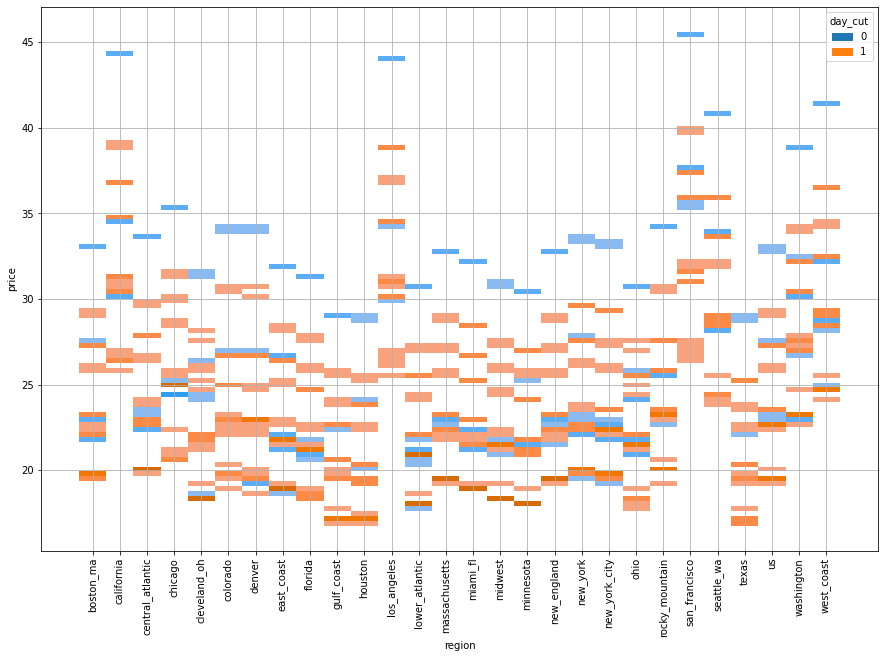

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(2)
sns.histplot(df3p, x="region", y="price", hue="day_cut", bins=100)
plt.xticks(rotation=90);


**Texas have the lowest gas price based on all other countries (plot in map).**

False

In [ ]:
df_lat_long_price = df4[["latitude", "longitude", "region", "price"]].groupby(["latitude", "longitude", "region"]).sum().reset_index()

df_lat_long_price.sort_values(by="price")

latitude 
 longitude 
 region 
 price 
 
 
 
 
 3 
 29.758938 
 -95.367697 
 houston 
 647.829 
 
 
 4 
 31.263890 
 -98.545612 
 texas 
 649.009 
 
 
 1 
 26.301135 
 -81.797742 
 gulf_coast 
 656.029 
 
 
 5 
 33.687439 
 -80.436374 
 lower_atlantic 
 695.589 
 
 
 25 
 45.989659 
 -94.611329 
 minnesota 
 695.852 
 
 
 13 
 40.225357 
 -82.688140 
 ohio 
 702.342 
 
 
 23 
 43.411391 
 -106.280075 
 midwest 
 705.911 
 
 
 2 
 27.756767 
 -81.463983 
 florida 
 709.189 
 
 
 18 
 41.539417 
 -81.635238 
 cleveland_oh 
 711.190 
 
 
 17 
 41.380611 
 -74.312665 
 east_coast 
 723.203 
 
 
 0 
 25.940876 
 -80.248586 
 miami_fl 
 725.963 
 
 
 24 
 44.205708 
 -70.753784 
 new_england 
 739.039 
 
 
 22 
 42.378877 
 -72.032366 
 massachusetts 
 739.803 
 
 
 11 
 39.739236 
 -104.984862 
 denver 
 741.757 
 
 
 9 
 38.725178 
 -105.607716 
 colorado 
 744.351 
 
 
 21 
 42.367970 
 -71.052616 
 boston_ma 
 744.459 
 
 
 12 
 39.783730 
 -100.445882 
 us 
 747.243 
 
 
 15 
 40.712728 
 -74.006015 
 new_york_city 
 747.353 
 
 
 14 
 40.712728 
 -74.006015 
 new_york 
 754.056 
 
 
 26 
 47.590493 
 -122.324313 
 central_atlantic 
 760.147 
 
 
 20 
 41.972870 
 -74.372651 
 rocky_mountain 
 762.160 
 
 
 19 
 41.875562 
 -87.624421 
 chicago 
 815.648 
 
 
 10 
 38.895037 
 -77.036543 
 washington 
 886.792 
 
 
 27 
 47.622137 
 -122.330131 
 seattle_wa 
 928.695 
 
 
 16 
 41.379707 
 -74.312051 
 west_coast 
 941.271 
 
 
 6 
 34.053691 
 -118.242766 
 los_angeles 
 1002.867 
 
 
 7 
 36.701463 
 -118.755997 
 california 
 1005.848 
 
 
 8 
 37.779259 
 -122.419329 
 san_francisco 
 1029.525

In [ ]:
fig = go.Figure(
    data=go.Scattergeo(
        lon=df_lat_long_price["longitude"],
        lat=df_lat_long_price["latitude"],
        text=df_lat_long_price["region"] + " - " + df_lat_long_price["price"].astype(str),
        marker=dict(
            size=df_lat_long_price["price"] / 50,
            color=df_lat_long_price["price"],
            colorscale="Viridis",
            colorbar=dict(title="Price")
        )
    )
)

fig.update_layout(title="Us Gas Price Scatter", geo_scope='usa')
fig.show()


### 5.3. Multivariate Analysis

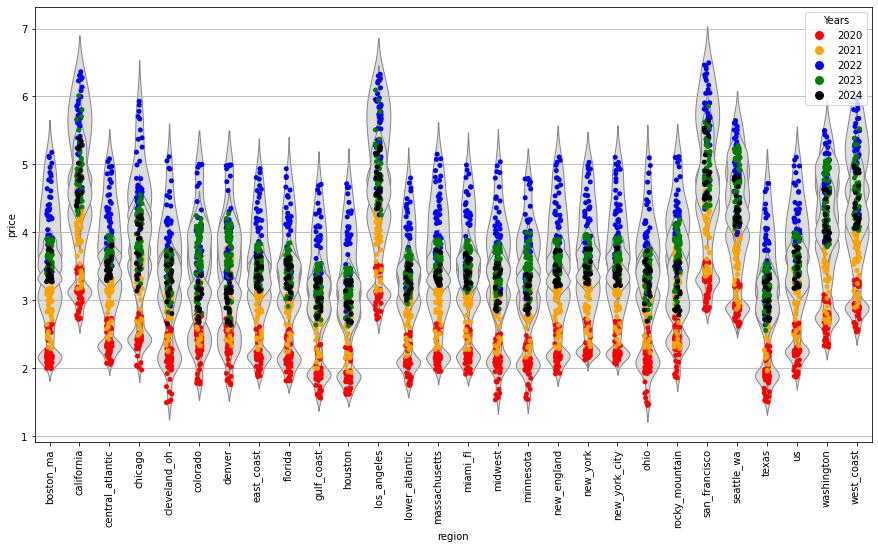

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.grid(2)
legend = []

for year, color in zip(df4.year.unique(), ["red", "orange", "blue", "green", "black"]):
    data = df4[df4["year"] == year]

    sns.violinplot(
        data=data,
        x="region",
        y="price",
        ax=ax,
        scale='width',
        inner=None,
        linewidth=1,
        color='#DDDDDD',
        saturation=1
    )

    axi = sns.stripplot(
        data=data,
        x="region",
        y="price",
        color=color,
        jitter=True,
        linewidth=0.01,
    )

    legend.append(plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=str(year)))

# Display the legend with the proxy artists
ax.legend(handles=legend, title="Years", loc="upper right")

plt.xticks(rotation=90);

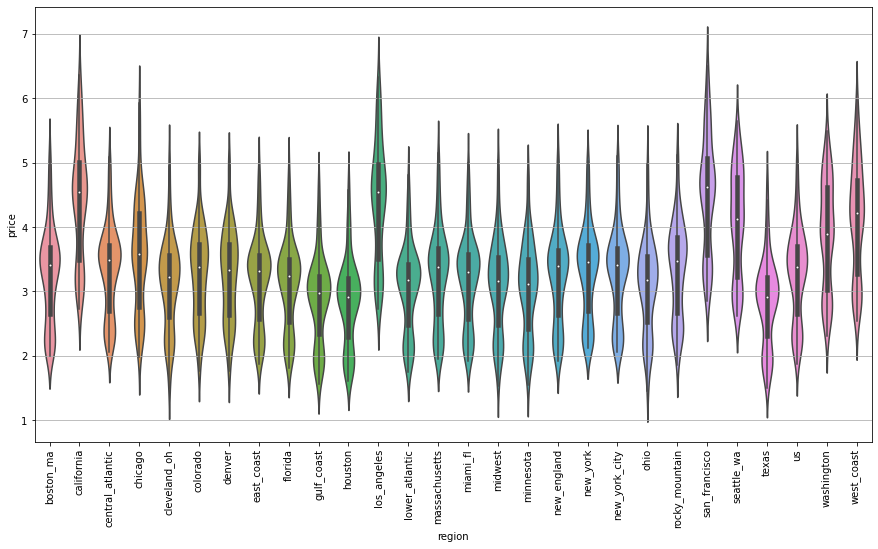

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.grid(2)
sns.violinplot(data=df4, x="region", y="price")
plt.xticks(rotation=90);

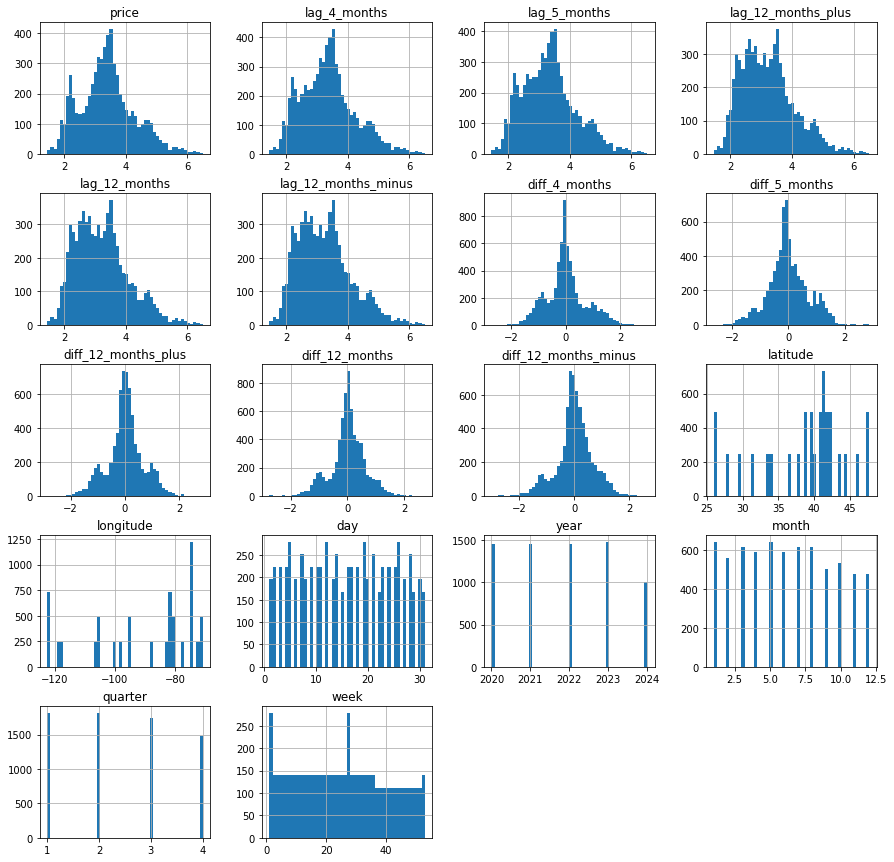

In [ ]:
df4.iloc[:, 2:].hist(
    bins=50, figsize=(15,15)
);

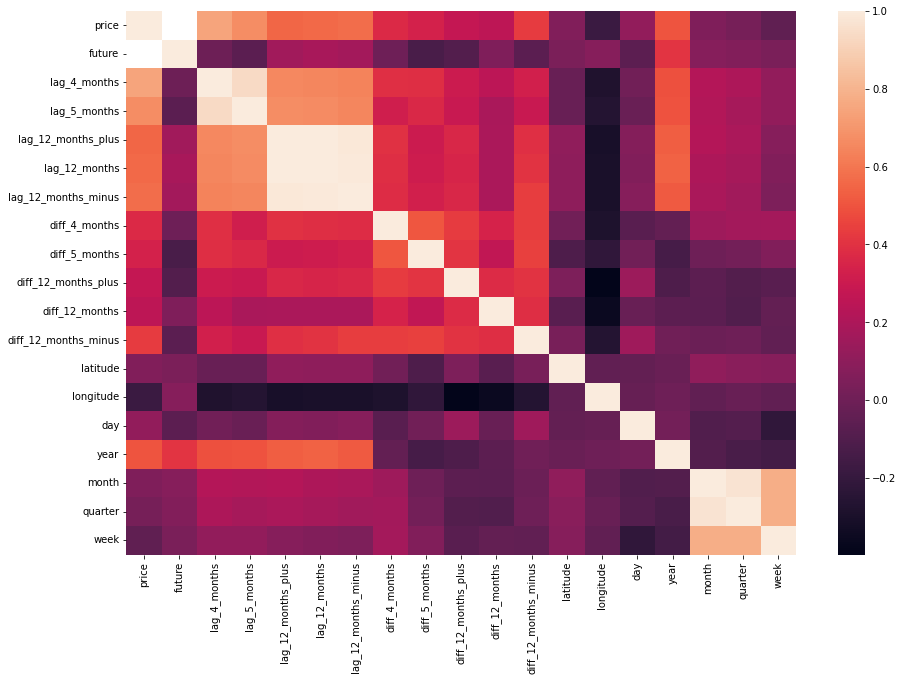

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df4.iloc[:, 2:].sample(100).corr(method="pearson"));

In [ ]:
corrs = df2.corr(method="pearson")

Out[613]: <seaborn.axisgrid.PairGrid at 0x7ff3eba60fd0>

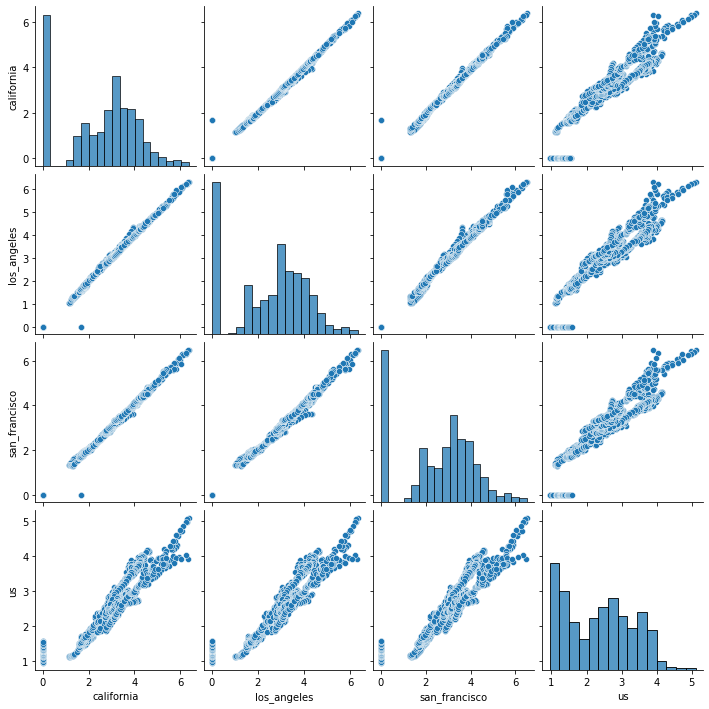

In [ ]:
sns.pairplot(df2[corrs[corrs.apply(lambda x: x < 0.95)].iloc[:, [0]].dropna().index.tolist() + ["us"]])


## 6.0. Data Preparation

In [ ]:
df6 = df4.copy()


### 6.1. Nature Transformation

In [ ]:
df6["day_sin"] = df6["day"].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df6["day_cos"] = df6["day"].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

df6["week_sin"] = df6["week"].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df6["week_cos"] = df6["week"].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

df6["month_sin"] = df6["month"].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df6["month_cos"] = df6["month"].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

df6["quarter_sin"] = df6["quarter"].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df6["quarter_cos"] = df6["quarter"].apply(lambda x: np.cos(x * (2. * np.pi / 12)))


### 6.2. Encoding

In [ ]:
region_mapping = {
    'boston_ma': 0,
    'california': 1,
    'central_atlantic': 2,
    'chicago': 3,
    'cleveland_oh': 4,
    'colorado': 5,
    'denver': 6,
    'east_coast': 7,
    'florida': 8,
    'gulf_coast': 9,
    'houston': 10,
    'los_angeles': 11,
    'lower_atlantic': 12,
    'massachusetts': 13,
    'miami_fl': 14,
    'midwest': 15,
    'minnesota': 16,
    'new_england': 17,
    'new_york': 18,
    'new_york_city': 19,
    'ohio': 20,
    'rocky_mountain': 21,
    'san_francisco': 22,
    'seattle_wa': 23,
    'texas': 24,
    'us': 25,
    'washington': 26,
    'west_coast': 27
}

df6.region = df6.region.map(region_mapping)


## 7.0. Feature Selection

In [ ]:
# Next Cycle


## 8.0. Machine Learning

In [ ]:
df8 = df6.copy()
f = (df8["future"] == True)

In [ ]:
train = df8[~f].copy()

date_train_test_cutoff = (train["date"].max() - pd.DateOffset(months=4)).strftime("%Y-%m") + "-01"

df_train = train[train["date"] < date_train_test_cutoff].reset_index(drop=True)
df_test = train[train["date"] >= date_train_test_cutoff].reset_index(drop=True)


### 8.1. Multivariable Forecasting Approach

In [ ]:
# Save on Databricks User
experiment_name = "/Users/gabrielrichter2021@gmail.com/grc-pandas-gas-price-forecast"

try:
    experiment_id = mlflow.get_experiment_by_name(name=experiment_name).experiment_id
except:
    experiment_id = mlflow.create_experiment(name=experiment_name)


#### 8.1.1 Baseline


We can define two main baselines, a "judgement" and or another very simple method such as mean.

A judgement is common in practice. In many cases, judgmental forecasting is the only option, such as when there is a complete lack of historical data, or when a new product is being launched, or when a new competitor enters the market, or during completely new and unique market conditions.

But we have a historical gas price, lets try fit a simple mean and calculate some metrics. 


##### 8.1.1.1. Baseline Cross Validation

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name=f"baseline-models"
) as active_run:
    
    for estimator_name in ["mean"]:
        
        if estimator_name == "mean":
            cv_results = cv_mean_baseline(
                df=train,
                model=MeanEstimator(),
                estimator_name=estimator_name
            )

            log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(cv_results)
            log_mean_metrics, log_std_metrics = pd.DataFrame(log_mean_metrics), pd.DataFrame(log_std_metrics)

        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            estimator_log_std_metrics = log_std_metrics[log_std_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            estimator_log_mean_metrics = log_mean_metrics[log_mean_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]

            mlflow.log_metrics(estimator_log_std_metrics)
            mlflow.log_metrics(estimator_log_mean_metrics)

In [ ]:
desc_metrics

estimator 
 mean 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 -1.584026 
 2.052962 
 -4.800482e+00 
 -2.875509e+00 
 -8.881852e-01 
 -8.597599e-02 
 0.618930 
 
 
 mse 
 10.0 
 0.895327 
 0.956984 
 1.485241e-01 
 2.996323e-01 
 5.323048e-01 
 8.214807e-01 
 2.976653 
 
 
 rmse 
 10.0 
 0.846541 
 0.445589 
 3.853882e-01 
 5.453803e-01 
 7.294415e-01 
 9.063294e-01 
 1.725298 
 
 
 sred 
 10.0 
 371.255422 
 224.245768 
 1.100428e+02 
 2.450595e+02 
 3.140499e+02 
 4.457221e+02 
 785.722446 
 
 
 pv_shap 
 10.0 
 0.000067 
 0.000209 
 9.356088e-17 
 9.598438e-14 
 5.973442e-11 
 1.275994e-08 
 0.000661 
 
 
 pv_norm 
 10.0 
 0.011784 
 0.037140 
 2.729651e-27 
 2.815667e-19 
 1.236838e-13 
 2.609490e-08 
 0.117486 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000e+00 
 10.000000


##### 8.1.1.2. Baseline Train & Test

In [ ]:
forecasting = pd.merge(
    df_test[["region", "price", "date"]],
    df_train[["region", "price"]].groupby("region").mean().reset_index().rename(columns={"price": "yhat"}),
    on="region"
)

dftp = df_train[["region", "date", "price"]].copy()
dftp["region"] = dftp["region"].map({v:k for k, v in region_mapping.items()})
forecasting["region"] = forecasting["region"].map({v:k for k, v in region_mapping.items()})

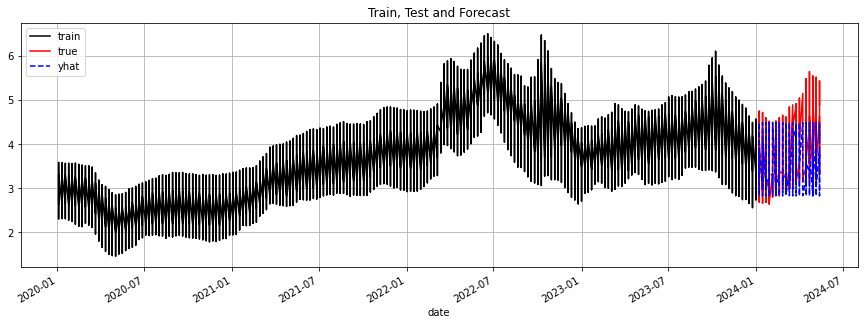

In [ ]:
plot_train_test_forecast(dftp, forecasting, date_col="date", ytrue="price", yhat="yhat");

Out[141]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -0.7436458109688888,
  'mse': 67.39479942382279,
  'rmse': 8.209433562909368,
  'sred': 101.86400000000012,
  'pv_shap': 0.04027258977293968,
  'pv_norm': 0.034513167220430345,
  'k': 1})

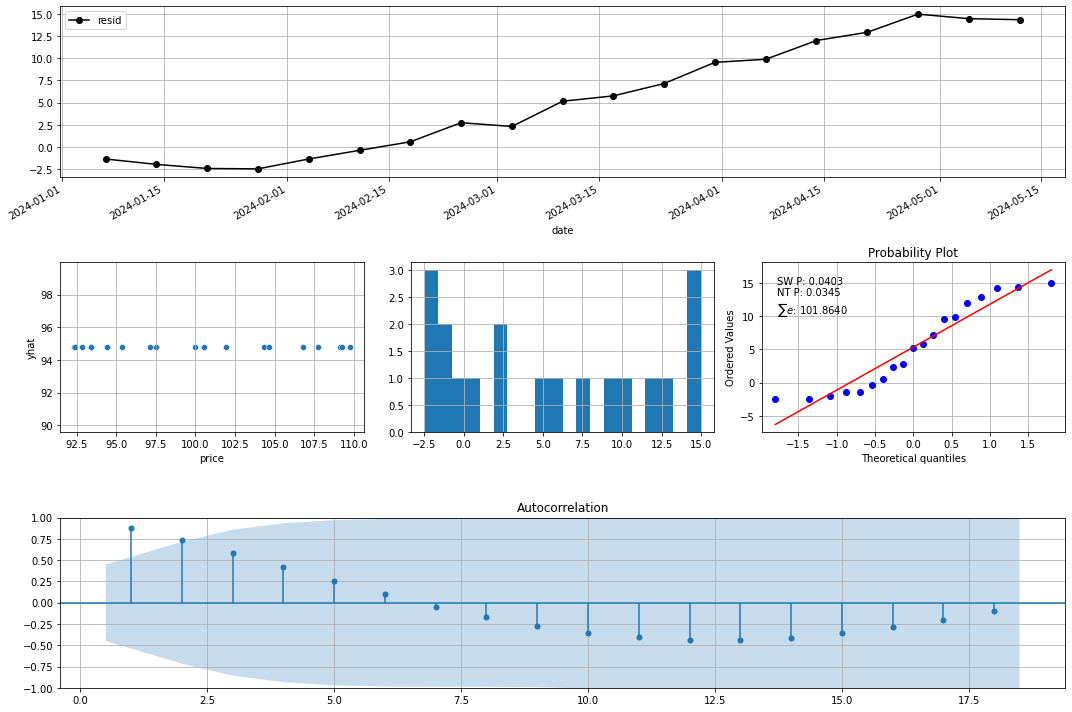

In [ ]:
plot_resid_analysis(
    forecasting,
    x="date",
    ytrue="price",
    yhat="yhat"
)


##### 8.1.1.3. Baseline Future

In [ ]:
forecasting = pd.merge(
    df8[f][["region", "date"]].reset_index(drop=2),
    df8[~f][["region", "date", "price"]].groupby("region").mean("price").reset_index(),
    on="region"
)

forecasting["region"] = forecasting["region"].map({v:k for k, v in region_mapping.items()})
dftp = df_test[["date", "price", "region"]].copy()
dftp["region"] = dftp["region"].map({v:k for k, v in region_mapping.items()})

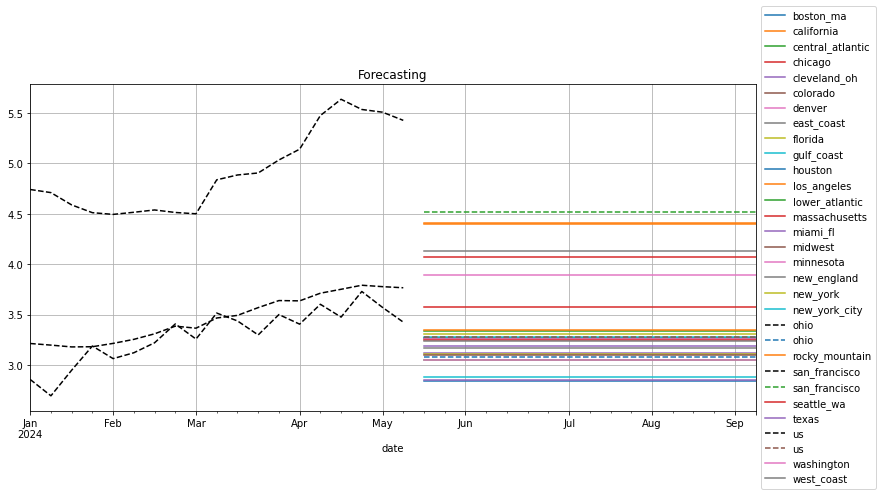

In [ ]:
plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);


#### 8.1.2. StatsForecast

In [ ]:
df_sf = df8[~f].copy()
df_sf = df_sf[["region", "date", "price"]]
df_sf.columns = ["unique_id", "ds", "y"]
df_sf["unique_id"] = df_sf["unique_id"].map({v:k for k, v in region_mapping.items()})

df_train = df_sf[df_sf["ds"] < date_train_test_cutoff].reset_index(drop=True)
df_test = df_sf[df_sf["ds"] >= date_train_test_cutoff].reset_index(drop=True)

In [ ]:
df_sf.head()

unique_id 
 ds 
 y 
 
 
 
 
 0 
 boston_ma 
 2020-01-05 
 2.643 
 
 
 1 
 california 
 2020-01-05 
 3.517 
 
 
 2 
 central_atlantic 
 2020-01-05 
 2.694 
 
 
 3 
 chicago 
 2020-01-05 
 2.731 
 
 
 4 
 cleveland_oh 
 2020-01-05 
 2.692


##### 8.1.2.1. Base StatsForecast


I can fine tuning seasonal length.

In docs is possbile to see if you have monthly data, "We set season_length to 12 because we expect seasonal effects every 12 months." and references to this post: (https://robjhyndman.com/hyndsight/seasonal-periods/).

For weekly data is expected to get "52" on seasonal length, the gas price "expect" to repat over year, but in plots you can see this pattern changes over time, not like white noise but is litle hard to see a pattern to be captured by any classical statistical forecasting methods that use smoothing or autocorrelated regressors for forecasting, i need a exog features or more regressors to add into account for forecasting.

If I resample the dataset with monthly data, i can try a forecast with seasonal length of 12 istead of try to "fine tuning" the seasonal length.

In [ ]:
models = [
    AutoARIMA(
        season_length=7,
        seasonal=True
    ),
    AutoETS(
        season_length=7,
        model="ZZZ"
    ),
    AutoCES(
        season_length=7
    ),
    AutoTheta(
        season_length=7
    )
]

sf = StatsForecast(
    models=models,
    freq="W"
)

description = """
### StatsForecast Fit
Nested Runs have estimators metrics for each run estimator.
I have stored StatsForecast object to mlflow model with all estimators tested inside.
[Github](https://github.com/Nixtla/statsforecast).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=sf,
        date_col="ds",
        target_col="y"
    )

    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(cv_results)
    log_mean_metrics, log_std_metrics = pd.DataFrame(log_mean_metrics), pd.DataFrame(log_std_metrics)

    for estimator_name in {estimator["estimator"] for estimator in cv_results}:
        print(f"Logging Model: {estimator_name}")

        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            estimator_log_std_metrics = log_std_metrics[log_std_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            estimator_log_mean_metrics = log_mean_metrics[log_mean_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]

            mlflow.log_metrics(estimator_log_std_metrics)
            mlflow.log_metrics(estimator_log_mean_metrics)


Logging Model: AutoARIMA
Logging Model: AutoTheta
Logging Model: CES
Logging Model: AutoETS


In [ ]:
desc_metrics

estimator 
 AutoARIMA 
 AutoETS 
 AutoTheta 
 CES 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 0.354270 
 0.472197 
 -3.714975e-01 
 2.822689e-02 
 4.753933e-01 
 0.761729 
 0.874759 
 10.0 
 0.254265 
 0.559647 
 -5.949602e-01 
 -2.436686e-01 
 4.713750e-01 
 0.684217 
 0.870573 
 10.0 
 0.315459 
 0.537114 
 -9.710854e-01 
 1.957978e-01 
 3.138342e-01 
 0.712410 
 0.882378 
 10.0 
 0.265622 
 0.697438 
 -1.568742e+00 
 2.293265e-01 
 3.020714e-01 
 0.680556 
 0.874799 
 
 
 mse 
 10.0 
 0.213980 
 0.169586 
 3.426182e-02 
 6.518484e-02 
 1.902361e-01 
 0.335951 
 0.526985 
 10.0 
 0.233285 
 0.168507 
 4.007649e-02 
 7.548883e-02 
 2.109437e-01 
 0.372563 
 0.514298 
 10.0 
 0.218487 
 0.150852 
 3.642117e-02 
 8.079485e-02 
 2.446059e-01 
 0.349172 
 0.419117 
 10.0 
 0.224819 
 0.155925 
 3.851697e-02 
 8.079912e-02 
 2.292573e-01 
 0.378839 
 0.407206 
 
 
 rmse 
 10.0 
 0.424633 
 0.193410 
 1.850995e-01 
 2.552470e-01 
 4.341786e-01 
 0.579468 
 0.725937 
 10.0 
 0.449051 
 0.187493 
 2.001911e-01 
 2.721536e-01 
 4.585526e-01 
 0.610379 
 0.717145 
 10.0 
 0.434761 
 0.180955 
 1.908433e-01 
 2.842415e-01 
 4.899650e-01 
 0.590640 
 0.647393 
 10.0 
 0.441156 
 0.183185 
 1.962574e-01 
 2.837476e-01 
 4.759864e-01 
 0.615112 
 0.638127 
 
 
 sred 
 10.0 
 44.693869 
 111.161446 
 -1.622681e+02 
 1.591636e+01 
 5.104903e+01 
 119.255759 
 201.797715 
 10.0 
 61.650621 
 116.891584 
 -1.690769e+02 
 1.462722e+01 
 7.686815e+01 
 147.332734 
 202.364404 
 10.0 
 37.710572 
 125.836151 
 -1.833860e+02 
 9.940276e-01 
 7.160761e+01 
 119.464201 
 175.688021 
 10.0 
 35.773109 
 127.319537 
 -1.794360e+02 
 5.739749e+00 
 7.330800e+01 
 99.765705 
 201.581107 
 
 
 pv_shap 
 10.0 
 0.000105 
 0.000236 
 8.516355e-12 
 8.690911e-10 
 2.654628e-08 
 0.000011 
 0.000712 
 10.0 
 0.000005 
 0.000010 
 1.291735e-16 
 3.911563e-10 
 1.157209e-06 
 0.000003 
 0.000028 
 10.0 
 0.000011 
 0.000023 
 6.975144e-14 
 3.104675e-11 
 2.059440e-07 
 0.000005 
 0.000074 
 10.0 
 0.000014 
 0.000020 
 2.513366e-15 
 9.611733e-11 
 1.183382e-07 
 0.000026 
 0.000051 
 
 
 pv_norm 
 10.0 
 0.008907 
 0.023522 
 3.184377e-21 
 5.289091e-12 
 2.012015e-04 
 0.002827 
 0.075410 
 10.0 
 0.000282 
 0.000779 
 1.604595e-231 
 8.030690e-15 
 1.604056e-07 
 0.000039 
 0.002484 
 10.0 
 0.000826 
 0.002551 
 3.468669e-156 
 9.858122e-16 
 6.255266e-07 
 0.000028 
 0.008086 
 10.0 
 0.000506 
 0.001281 
 1.994679e-153 
 1.968811e-11 
 1.474660e-06 
 0.000058 
 0.004066 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


##### 8.1.2.2. Base StatsForecast Train & Test

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-stats-train-test",
    description=description
) as active_run:
    sf.fit(df_train)
    forecasting = sf.forecast(h=df_test["ds"].nunique()).reset_index()
    forecasting = pd.merge(df_test, forecasting, on=["unique_id", "ds"])
    metrics = pd.DataFrame([get_ml_metrics(forecasting, ytrue="y", yhat=str(m)) | {"estimator": str(m)} for m in sf.models]).drop(columns="k", axis=1)

    for estimator_name in metrics["estimator"].unique():
        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            log_metrics = metrics[metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            mlflow.log_metrics(log_metrics)

    #mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")


In [ ]:
metrics

r2 
 mse 
 rmse 
 sred 
 pv_shap 
 pv_norm 
 estimator 
 
 
 
 
 0 
 0.738995 
 0.101638 
 0.318808 
 93.296786 
 3.919564e-12 
 3.170874e-09 
 AutoARIMA 
 
 
 1 
 0.611847 
 0.151151 
 0.388781 
 140.787896 
 5.174154e-12 
 1.884397e-07 
 AutoETS 
 
 
 2 
 0.665989 
 0.130068 
 0.360649 
 123.104577 
 7.091292e-12 
 1.716515e-07 
 CES 
 
 
 3 
 0.722126 
 0.108207 
 0.328949 
 106.777576 
 2.638142e-12 
 6.105214e-08 
 AutoTheta

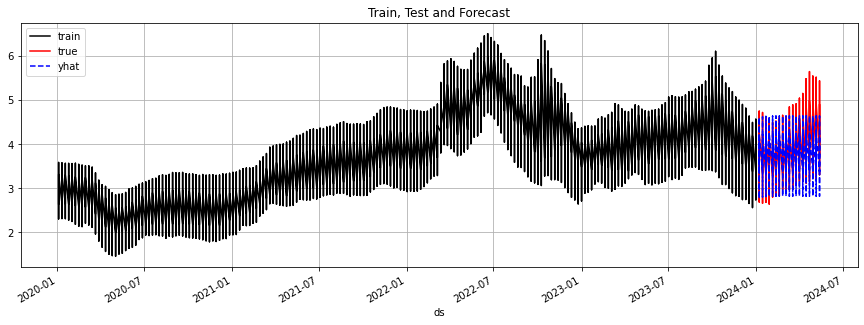

In [ ]:
plot_train_test_forecast(df_train, forecasting, date_col="ds", ytrue="y", yhat="AutoARIMA");

Out[214]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -0.6006428126714318,
  'mse': 61.86749661574444,
  'rmse': 7.865589400403789,
  'sred': 93.29678149414065,
  'pv_shap': 0.042220182716846466,
  'pv_norm': 0.035479487245127415,
  'k': 1})

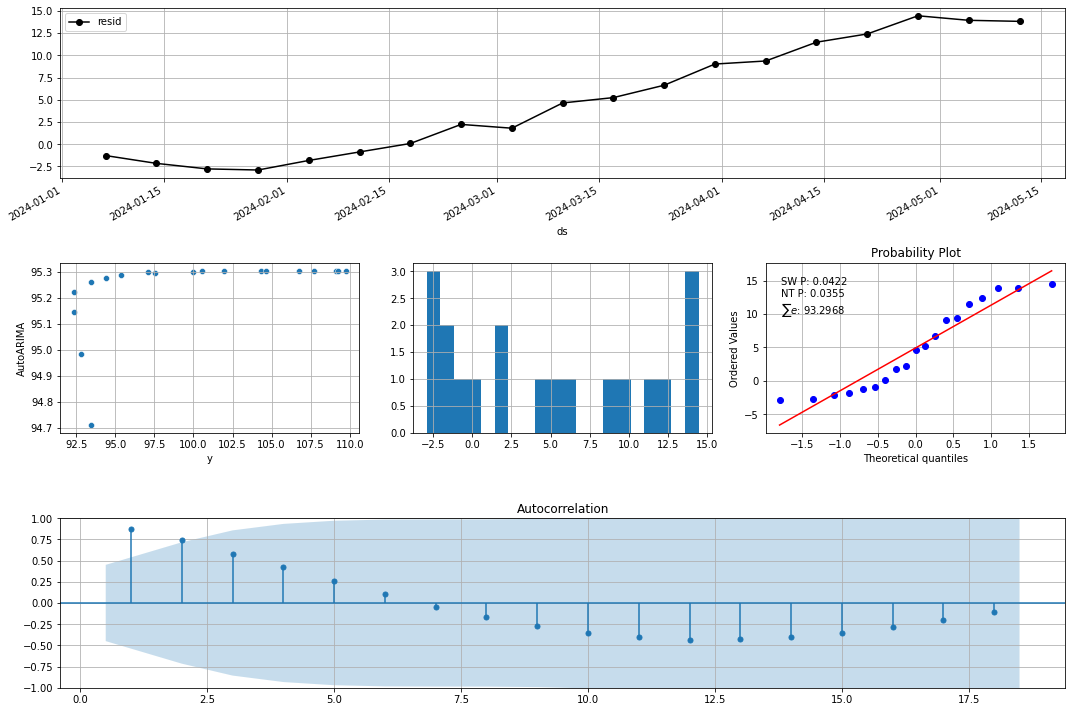

In [ ]:
plot_resid_analysis(
    forecasting,
    x="ds",
    ytrue="y",
    yhat="AutoARIMA"
)


##### 8.1.2.3. Base StatsForecast Future

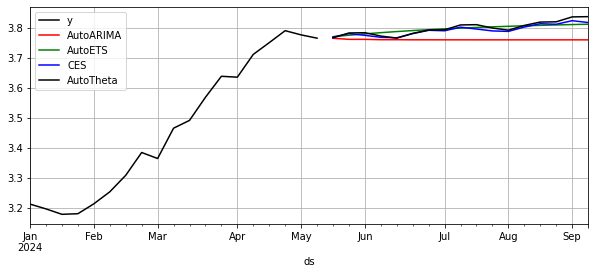

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-stats-full",
    description=description
) as active_run:
    sf.fit(df_sf)
    forecasting = sf.forecast(h=df8[f]["date"].nunique()).reset_index()

    fig, ax = plt.subplots(figsize=(10, 4))
    df_sf[(df_sf.unique_id == "us") & (df_sf["ds"] >= "2024-01-01")].plot(x="ds", y="y", color="k", ax=ax)

    for model, color in zip(sf.models, ["r", "g", "b", "k"]):
        forecast_model = forecasting[forecasting.columns[forecasting.columns.str.contains(str(model))].tolist() + ["unique_id", "ds"]]
        forecast_model = forecast_model[forecast_model["unique_id"] == "us"]
        forecast_model.plot(x="ds", y=str(model), ax=ax, grid=2, color=color)

    mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")


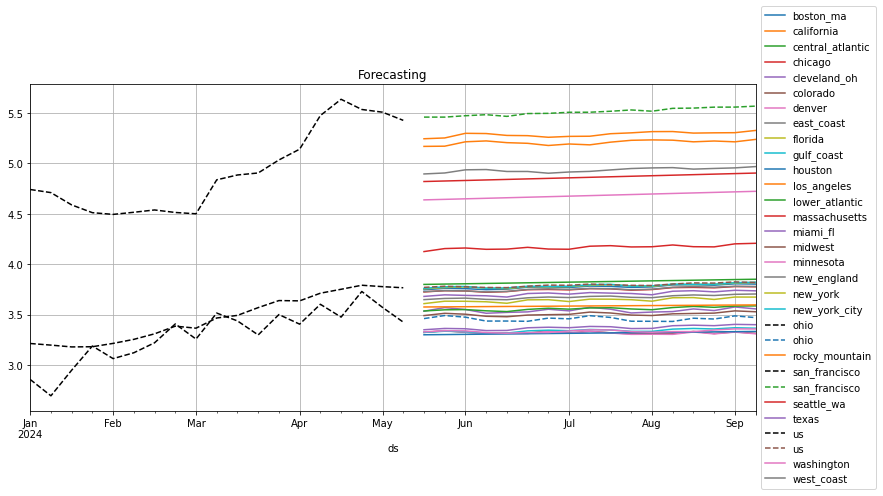

In [ ]:
plot_future_multiple_forecasting(
    df_history=df_sf,
    df_forecasting=forecasting,
    target_col="y",
    forecasting_col="CES"
);


##### 8.1.2.4. Resampling and Seasonal Length


If i try seasonal length of 52, nixtla show error because i do not have complete cyclic period of 52 weeks (i training and validating in a window of 4 months not complete 52 weeks).

The seasonal length in this case can be a hyperparam to tuning but can take a long time.

In [ ]:
models = [
    AutoARIMA(
        season_length=21,
        seasonal=True
    ),
    AutoETS(
        season_length=21,
        model="ZZZ"
    ),
    AutoCES(
        season_length=21
    ),
    AutoTheta(
        season_length=21
    )
]

sf = StatsForecast(
    models=models,
    freq="W"
)

description = """
### StatsForecast Fit
Nested Runs have estimators metrics for each run estimator.
I have stored StatsForecast object to mlflow model with all estimators tested inside.
[Github](https://github.com/Nixtla/statsforecast).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=sf,
        date_col="ds",
        target_col="y"
    )

    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(cv_results)
    log_mean_metrics, log_std_metrics = pd.DataFrame(log_mean_metrics), pd.DataFrame(log_std_metrics)

    for estimator_name in {estimator["estimator"] for estimator in cv_results}:
        print(f"Logging Model: {estimator_name}")

        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            estimator_log_std_metrics = log_std_metrics[log_std_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            estimator_log_mean_metrics = log_mean_metrics[log_mean_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]

            mlflow.log_metrics(estimator_log_std_metrics)
            mlflow.log_metrics(estimator_log_mean_metrics)


Logging Model: AutoARIMA
Logging Model: AutoTheta
Logging Model: CES
Logging Model: AutoETS



With 21 seasonal length, the metrics do not changed a lot, Arima become a bit more wrost than arima with seasonal length of 7 in first fit.

In [ ]:
desc_metrics

estimator 
 AutoARIMA 
 AutoETS 
 AutoTheta 
 CES 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 0.233691 
 0.597014 
 -6.692121e-01 
 -2.985644e-01 
 4.631403e-01 
 0.738805 
 0.872075 
 10.0 
 0.260447 
 0.531291 
 -4.895077e-01 
 -2.679429e-01 
 4.749992e-01 
 0.674734 
 0.864229 
 10.0 
 0.312621 
 0.538138 
 -9.710854e-01 
 1.849870e-01 
 3.071803e-01 
 0.704484 
 0.885424 
 10.0 
 0.172653 
 0.974357 
 -2.513304e+00 
 2.481966e-01 
 3.880074e-01 
 0.612855 
 0.884021 
 
 
 mse 
 10.0 
 0.240954 
 0.179384 
 3.961135e-02 
 6.871499e-02 
 2.433015e-01 
 0.361674 
 0.513521 
 10.0 
 0.234128 
 0.166556 
 4.204087e-02 
 7.547170e-02 
 2.279775e-01 
 0.346675 
 0.512075 
 10.0 
 0.218556 
 0.148583 
 3.547779e-02 
 8.249708e-02 
 2.482438e-01 
 0.355074 
 0.394554 
 10.0 
 0.231551 
 0.165025 
 3.591218e-02 
 1.077384e-01 
 2.364443e-01 
 0.316564 
 0.553682 
 
 
 rmse 
 10.0 
 0.452397 
 0.200806 
 1.990260e-01 
 2.618802e-01 
 4.928485e-01 
 0.601393 
 0.716604 
 10.0 
 0.450778 
 0.185372 
 2.050387e-01 
 2.728436e-01 
 4.774174e-01 
 0.588776 
 0.715594 
 10.0 
 0.435210 
 0.179964 
 1.883555e-01 
 2.872200e-01 
 4.942263e-01 
 0.595669 
 0.628136 
 10.0 
 0.448812 
 0.182937 
 1.895051e-01 
 3.281372e-01 
 4.826472e-01 
 0.562641 
 0.744098 
 
 
 sred 
 10.0 
 48.807123 
 115.753805 
 -1.688243e+02 
 1.360411e+01 
 4.755826e+01 
 132.878934 
 197.963739 
 10.0 
 61.369484 
 118.136496 
 -1.606615e+02 
 1.871214e+01 
 7.390882e+01 
 149.043630 
 201.636550 
 10.0 
 39.385586 
 124.384080 
 -1.704365e+02 
 -1.931809e+00 
 7.026796e+01 
 124.186773 
 175.688021 
 10.0 
 47.125528 
 123.864517 
 -1.624853e+02 
 1.631168e+01 
 7.617773e+01 
 98.969153 
 243.093345 
 
 
 pv_shap 
 10.0 
 0.000033 
 0.000096 
 1.897762e-15 
 3.271166e-08 
 1.076198e-07 
 0.000007 
 0.000306 
 10.0 
 0.000010 
 0.000020 
 2.848846e-16 
 6.077890e-09 
 1.312109e-07 
 0.000010 
 0.000060 
 10.0 
 0.000027 
 0.000062 
 2.796100e-14 
 2.646994e-11 
 1.711783e-08 
 0.000003 
 0.000191 
 10.0 
 0.000001 
 0.000002 
 3.940175e-13 
 1.713917e-09 
 9.204326e-09 
 0.000002 
 0.000005 
 
 
 pv_norm 
 10.0 
 0.000769 
 0.002163 
 1.478938e-21 
 5.830059e-09 
 1.628257e-06 
 0.000039 
 0.006891 
 10.0 
 0.000740 
 0.001760 
 5.297470e-217 
 1.112053e-14 
 1.411951e-09 
 0.000021 
 0.005446 
 10.0 
 0.003074 
 0.009489 
 3.162490e-163 
 9.053891e-16 
 2.769770e-10 
 0.000087 
 0.030075 
 10.0 
 0.000163 
 0.000422 
 3.801913e-43 
 1.660999e-11 
 1.113260e-07 
 0.000038 
 0.001348 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


##### 8.1.2.5. MSTL


The MSTL model (Multiple Seasonal-Trend decomposition using LOESS) is a method used to decompose a time series into its seasonal, trend and residual components. This approach is based on the use of LOESS (Local Regression Smoothing) to estimate the components of the time series.

The MSTL decomposition is an extension of the classic seasonal-trend decomposition method (also known as Holt-Winters decomposition), which is designed to handle situations where multiple seasonal patterns exist in the data. This can occur, for example, when a time series exhibits daily, weekly, and yearly patterns simultaneously.

Traditionally, STL is the best decomposition model for time series in classic methods (https://otexts.com/fpp2/stl.html), MSTL use STL to decompose and forecasting, but i need to forecast the components of the series, maybe can be very hard too (https://otexts.com/fpp2/complexseasonality.html).

I will use this method from nixtla package:

- https://nixtlaverse.nixtla.io/statsforecast/docs/tutorials/multipleseasonalities.html

In [ ]:
models = [MSTL(season_length=[52], trend_forecaster=AutoARIMA())]

sf = StatsForecast(models=models, freq="W")

description = """
### StatsForecast Fit
MSTL Training with multiple arbitrary seasonal lengths
[Github](https://nixtlaverse.nixtla.io/statsforecast/docs/tutorials/multipleseasonalities.html).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=sf,
        date_col="ds",
        target_col="y"
    )

    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(cv_results)
    log_mean_metrics, log_std_metrics = pd.DataFrame(log_mean_metrics), pd.DataFrame(log_std_metrics)

    for estimator_name in {estimator["estimator"] for estimator in cv_results}:
        print(f"Logging Model: {estimator_name}")

        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            estimator_log_std_metrics = log_std_metrics[log_std_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            estimator_log_mean_metrics = log_mean_metrics[log_mean_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]

            mlflow.log_metrics(estimator_log_std_metrics)
            mlflow.log_metrics(estimator_log_mean_metrics)


Logging Model: MSTL



The metrics change a bit, lets try a full fit and future forecasting.

In [ ]:
desc_metrics

estimator 
 MSTL 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 -0.568205 
 1.059417 
 -2.154775e+00 
 -1.341726e+00 
 -3.158048e-01 
 0.236156 
 0.785661 
 
 
 mse 
 10.0 
 0.418052 
 0.200855 
 1.121008e-01 
 2.961207e-01 
 3.949767e-01 
 0.565425 
 0.742637 
 
 
 rmse 
 10.0 
 0.627030 
 0.166281 
 3.348146e-01 
 5.429178e-01 
 6.284656e-01 
 0.751529 
 0.861764 
 
 
 sred 
 10.0 
 22.121238 
 203.425873 
 -2.578792e+02 
 -1.746515e+02 
 9.313521e+01 
 172.495214 
 262.800275 
 
 
 pv_shap 
 10.0 
 0.000024 
 0.000060 
 3.853592e-16 
 3.700879e-10 
 4.107236e-07 
 0.000003 
 0.000190 
 
 
 pv_norm 
 10.0 
 0.001975 
 0.004455 
 3.952093e-60 
 1.023789e-17 
 3.008404e-06 
 0.000950 
 0.014218 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


##### 8.1.2.6. MSTL Train & Test

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-mstl-train-test",
    description=description
) as active_run:
    sf.fit(df_train)
    forecasting = sf.forecast(h=df_test["ds"].nunique()).reset_index()
    forecasting = pd.merge(df_test, forecasting, on=["unique_id", "ds"])
    metrics = pd.DataFrame([get_ml_metrics(forecasting, ytrue="y", yhat=str(m)) | {"estimator": str(m)} for m in sf.models]).drop(columns="k", axis=1)

    for estimator_name in metrics["estimator"].unique():
        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            log_metrics = metrics[metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            mlflow.log_metrics(log_metrics)

    #mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")


In [ ]:
metrics

r2 
 mse 
 rmse 
 sred 
 pv_shap 
 pv_norm 
 estimator 
 
 
 
 
 0 
 0.616644 
 0.149283 
 0.386372 
 -161.423731 
 1.663027e-16 
 1.142577e-25 
 MSTL

Out[223]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -1.0742205520510644,
  'mse': 80.17206085482155,
  'rmse': 8.953885237974717,
  'sred': -161.4237308959961,
  'pv_shap': 0.14646337926387787,
  'pv_norm': 0.07393836644365522,
  'k': 1})

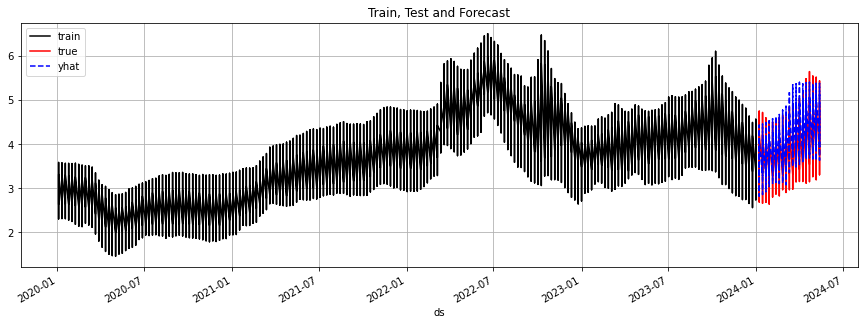

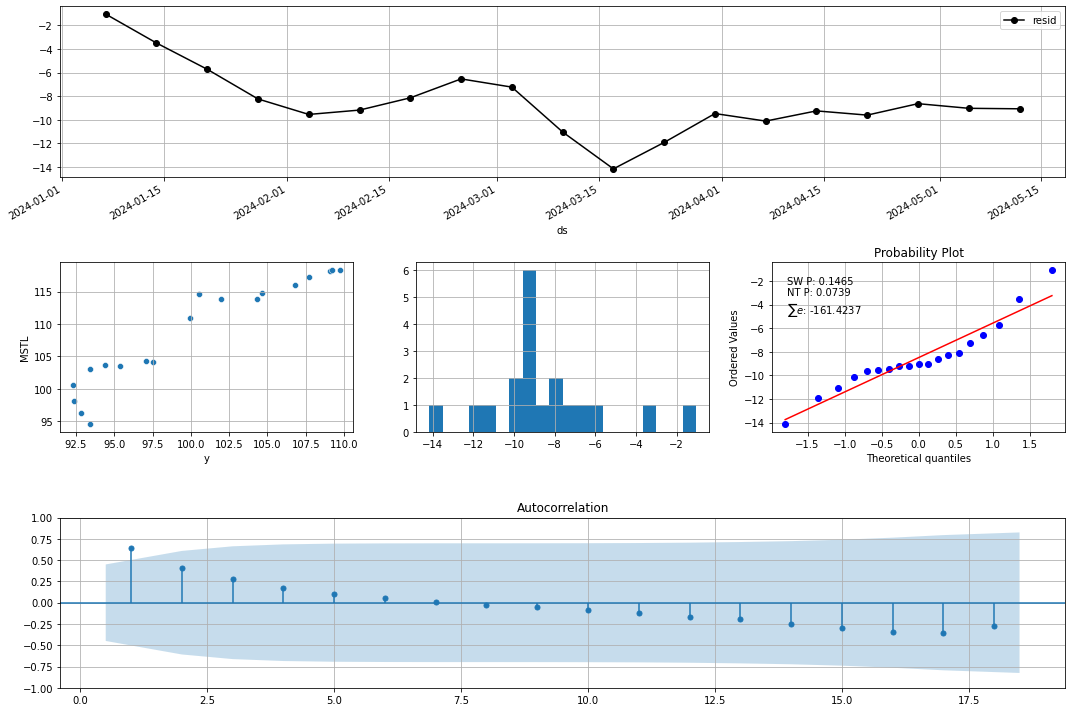

In [ ]:
plot_train_test_forecast(df_train, forecasting, date_col="ds", ytrue="y", yhat="MSTL");

plot_resid_analysis(
    forecasting,
    x="ds",
    ytrue="y",
    yhat="MSTL"
)


##### 8.1.2.7. MSTL Future Forecasting

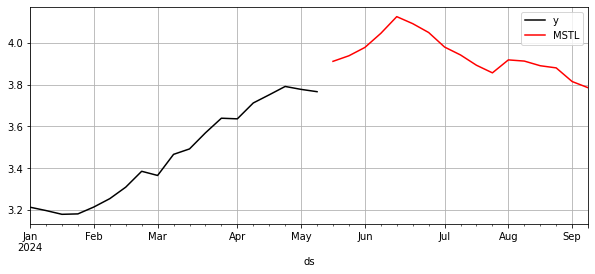

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-mstl-full",
    description=description
) as active_run:
    sf.fit(df_sf)
    forecasting = sf.forecast(h=df8[f]["date"].nunique()).reset_index()

    fig, ax = plt.subplots(figsize=(10, 4))
    df_sf[(df_sf.unique_id == "us") & (df_sf["ds"] >= "2024-01-01")].plot(x="ds", y="y", color="k", ax=ax)

    for model, color in zip(sf.models, ["r", "g", "b"]):
        forecast_model = forecasting[forecasting.columns[forecasting.columns.str.contains(str(model))].tolist() + ["unique_id", "ds"]]
        forecast_model = forecast_model[forecast_model["unique_id"] == "us"]
        forecast_model.plot(x="ds", y=str(model), ax=ax, grid=2, color=color)

    mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")


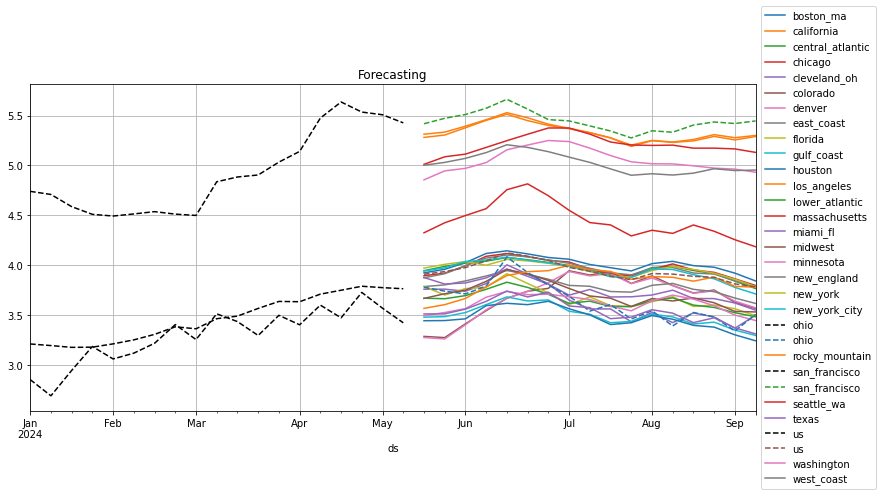

In [ ]:
plot_future_multiple_forecasting(
    df_history=df_sf,
    df_forecasting=forecasting,
    target_col="y",
    forecasting_col="MSTL"
);

In [ ]:
print(f"Model Run Id: {active_run.info.run_uuid}")

sf_loaded = mlflow.pyfunc.load_model(
    f"runs:/{active_run.info.run_uuid}/models/sf_object"
)

sf_loaded.predict(1).head()

Model Run Id: f468cab04a9e4371a71a9a68c9d459bf


ds 
 MSTL 
 
 
 unique_id 
 
 
 
 
 
 
 boston_ma 
 2024-05-19 
 3.924873 
 
 
 california 
 2024-05-19 
 5.313227 
 
 
 central_atlantic 
 2024-05-19 
 3.946774 
 
 
 chicago 
 2024-05-19 
 4.326187 
 
 
 cleveland_oh 
 2024-05-19 
 3.761247


#### 8.1.3. MLForecast


MLForecast is a very great tool for forecasting with Machine Learning, you can use optuna too for fine tuning the estimators and create a infitite possibility of new features just mapping on a list. (https://forecastegy.com/posts/multiple-time-series-forecasting-with-lightgbm-in-python/).

In [ ]:
mlflow.autolog(disable=True)


##### 8.1.3.1. Base MlForecast

In [ ]:
mlf = MLForecast(
    freq="W",
    models=[
        KNeighborsRegressor(
            n_neighbors=10
        ),
        DecisionTreeRegressor(
            max_leaf_nodes=20
        )
    ],
    target_transforms=[
        Differences([7])
    ],
    lag_transforms={ 
        17: [
            (rolling_mean, 2),
            (rolling_mean, 3),
            (ewm_mean, 0.9),
            expanding_mean,
            (rolling_min,7),
            (rolling_max,7),
            (rolling_std,2),
            (rolling_std,3),
        ],
    },
    lags=[2, 3, 4 ,5], #, 14, 21, 28],
    date_features=[
        "month",
        "year",
        "day_of_week",
        "day_of_year",
        "is_month_start",
        "quarter",
        "days_in_month"
    ],
    num_threads=4
)

description = """
### MLForecast Fit
Nested Runs have estimators metrics for each run estimator.
I have stored MLForecast object to mlflow model with all estimators tested inside.
[Github](https://github.com/Nixtla/mlforecast).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="mlforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=mlf,
        date_col="ds",
        target_col="y"
    )

    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(cv_results)
    log_mean_metrics, log_std_metrics = pd.DataFrame(log_mean_metrics), pd.DataFrame(log_std_metrics)

    for estimator_name in {estimator["estimator"] for estimator in cv_results}:
        print(f"Logging Model: {estimator_name}")

        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            estimator_log_std_metrics = log_std_metrics[log_std_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            estimator_log_mean_metrics = log_mean_metrics[log_mean_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]

            mlflow.log_metrics(estimator_log_std_metrics)
            mlflow.log_metrics(estimator_log_mean_metrics)

Logging Model: DecisionTreeRegressor
Logging Model: KNeighborsRegressor


In [ ]:
desc_metrics

estimator 
 DecisionTreeRegressor 
 KNeighborsRegressor 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 -0.440944 
 1.385916 
 -3.823143e+00 
 -7.023651e-01 
 -4.641579e-01 
 0.589188 
 0.872183 
 10.0 
 0.263599 
 0.612727 
 -9.521190e-01 
 -1.725580e-01 
 4.485345e-01 
 0.723072 
 0.907454 
 
 
 mse 
 10.0 
 0.487245 
 0.549182 
 2.556908e-02 
 1.337047e-01 
 3.581029e-01 
 0.510235 
 1.877359 
 10.0 
 0.262540 
 0.247849 
 1.851335e-02 
 7.862025e-02 
 1.746238e-01 
 0.401160 
 0.793272 
 
 
 rmse 
 10.0 
 0.613516 
 0.350940 
 1.599034e-01 
 3.577309e-01 
 5.977956e-01 
 0.713127 
 1.370167 
 10.0 
 0.457778 
 0.242621 
 1.360638e-01 
 2.803916e-01 
 4.111982e-01 
 0.633242 
 0.890658 
 
 
 sred 
 10.0 
 -32.014655 
 186.612518 
 -3.545588e+02 
 -1.466041e+02 
 4.901490e+00 
 109.350545 
 180.092951 
 10.0 
 -30.985610 
 119.145999 
 -2.874451e+02 
 -8.752540e+01 
 1.236845e+01 
 52.583425 
 81.398700 
 
 
 pv_shap 
 10.0 
 0.002537 
 0.007835 
 1.341641e-18 
 2.555220e-08 
 6.799821e-07 
 0.000003 
 0.024832 
 10.0 
 0.000315 
 0.000815 
 1.346472e-13 
 4.429666e-08 
 1.947663e-07 
 0.000128 
 0.002608 
 
 
 pv_norm 
 10.0 
 0.004736 
 0.013678 
 2.032752e-33 
 6.257137e-10 
 1.035539e-05 
 0.000824 
 0.043596 
 10.0 
 0.000674 
 0.002009 
 1.434193e-27 
 8.731538e-08 
 6.467280e-06 
 0.000063 
 0.006389 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


#### 8.1.4. Sklearn

In [ ]:
df_train.drop(columns="future", inplace=True)
df_test.drop(columns="future", inplace=True)

In [ ]:
x_train = df_train.drop(columns=["price", "date"], axis=1)
y_train = df_train["price"].values

x_test = df_test.drop(columns=["price", "date"], axis=1)
y_test = df_test["price"].values

In [ ]:
x_train.head()

region 
 lag_4_months 
 lag_5_months 
 lag_12_months_plus 
 lag_12_months 
 lag_12_months_minus 
 diff_4_months 
 diff_5_months 
 diff_12_months_plus 
 diff_12_months 
 diff_12_months_minus 
 latitude 
 longitude 
 day 
 year 
 month 
 quarter 
 week 
 day_sin 
 day_cos 
 week_sin 
 week_cos 
 month_sin 
 month_cos 
 quarter_sin 
 quarter_cos 
 
 
 
 
 0 
 0 
 2.739 
 2.806 
 2.651 
 2.603 
 2.539 
 -0.741 
 0.139 
 0.160 
 0.476 
 0.146 
 42.367970 
 -71.052616 
 5 
 2020 
 1 
 1 
 1 
 0.866025 
 0.5 
 0.120537 
 0.992709 
 0.5 
 0.866025 
 0.5 
 0.866025 
 
 
 1 
 1 
 3.569 
 3.625 
 3.332 
 3.296 
 3.261 
 1.151 
 0.880 
 1.127 
 0.823 
 0.909 
 36.701463 
 -118.755997 
 5 
 2020 
 1 
 1 
 1 
 0.866025 
 0.5 
 0.120537 
 0.992709 
 0.5 
 0.866025 
 0.5 
 0.866025 
 
 
 2 
 2 
 2.697 
 2.853 
 2.530 
 2.491 
 2.467 
 -0.026 
 0.167 
 -0.023 
 0.065 
 0.094 
 47.590493 
 -122.324313 
 5 
 2020 
 1 
 1 
 1 
 0.866025 
 0.5 
 0.120537 
 0.992709 
 0.5 
 0.866025 
 0.5 
 0.866025 
 
 
 3 
 3 
 2.879 
 3.193 
 2.346 
 2.239 
 2.237 
 0.410 
 0.661 
 -0.143 
 -0.189 
 -0.032 
 41.875562 
 -87.624421 
 5 
 2020 
 1 
 1 
 1 
 0.866025 
 0.5 
 0.120537 
 0.992709 
 0.5 
 0.866025 
 0.5 
 0.866025 
 
 
 4 
 4 
 2.622 
 2.762 
 2.102 
 2.014 
 2.011 
 0.070 
 0.192 
 -0.357 
 -0.318 
 -0.040 
 41.539417 
 -81.635238 
 5 
 2020 
 1 
 1 
 1 
 0.866025 
 0.5 
 0.120537 
 0.992709 
 0.5 
 0.866025 
 0.5 
 0.866025


##### 8.1.4.1. Decision Tree

         r2      mse      rmse       sred       pv_shap   pv_norm  k
0  0.607407  0.15288  0.390999 -67.437129  2.194952e-08  0.000019  1


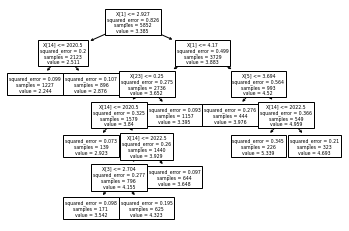

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-dtr-basic"
) as active_run:
    dtr = DecisionTreeRegressor(
        min_samples_leaf=20,
        max_leaf_nodes=10
    )

    dtr.fit(x_train, y_train)
    yhat = dtr.predict(x_test)

    forecasting = pd.DataFrame({"yhat": yhat, "price": y_test, "date": df_test["date"].values})
    metrics = get_ml_metrics(forecasting, ytrue="price", yhat="yhat")

    fig = plot_tree(dtr);
    print(pd.DataFrame(metrics, index=[0]))

    mlflow.log_metrics(metrics)

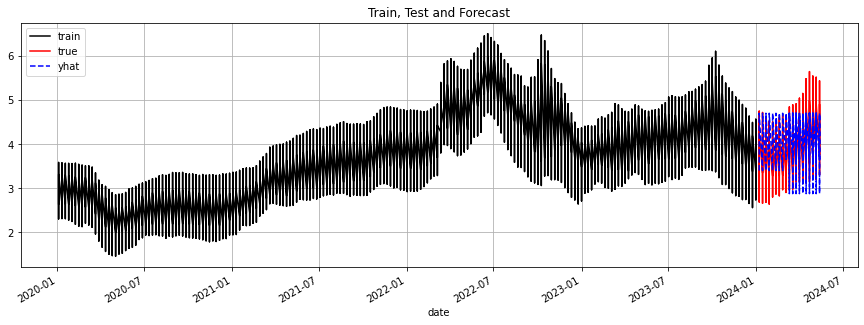

In [ ]:
plot_train_test_forecast(
    df_train,
    forecasting,
    date_col="date",
    ytrue="price",
    yhat="yhat"
);

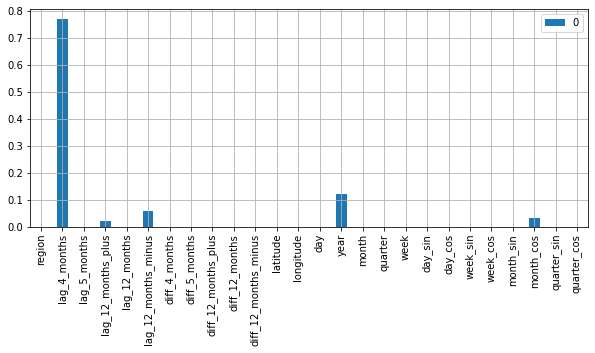

In [ ]:
pd.DataFrame({k: v for k, v in zip(x_train.columns, dtr.feature_importances_)}, index=[0]).T.plot(kind="bar", grid=2, figsize=(10, 4));

Out[330]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -0.7360704735894763,
  'mse': 67.10200008347418,
  'rmse': 8.191581049069477,
  'sred': -67.43712914604339,
  'pv_shap': 0.009572372771799564,
  'pv_norm': 0.20336339610246654,
  'k': 1})

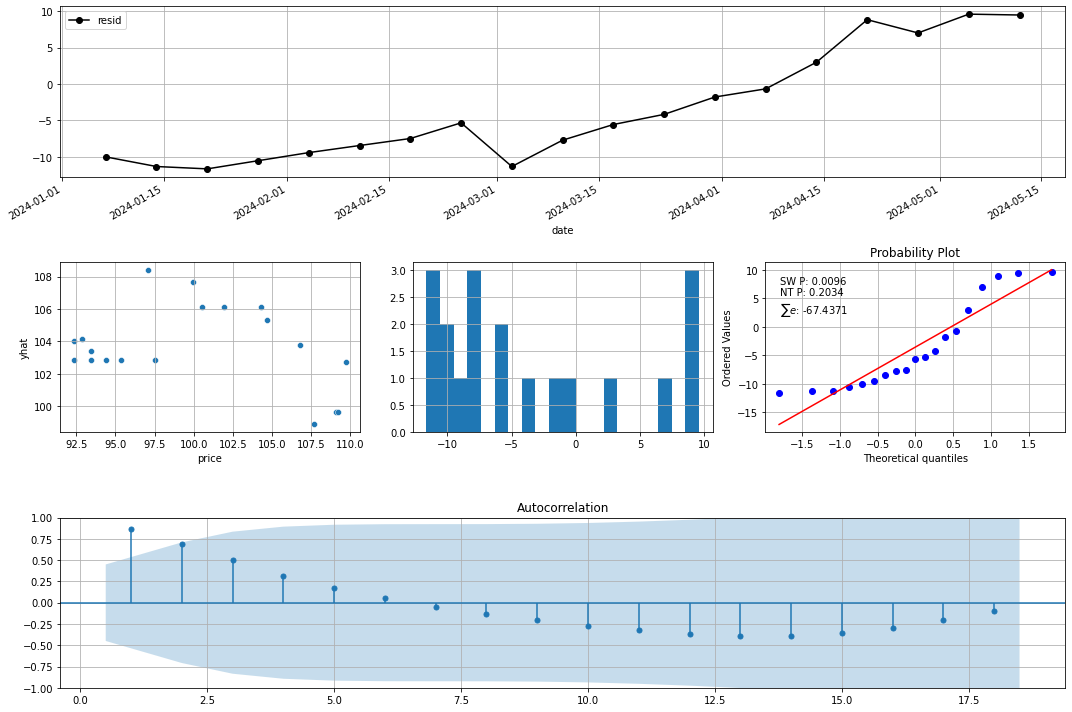

In [ ]:
plot_resid_analysis(forecasting, ytrue="price", yhat="yhat")


##### 8.1.4.2. XGBoost

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-basic"
) as active_run:
    xgb = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=50,
        max_depth=5
    )

    xgb.fit(x_train, y_train, verbose=True)
    yhat = xgb.predict(x_test)

    forecasting = pd.DataFrame({"yhat": yhat, "price": y_test, "date": df_test["date"].values})
    metrics = get_ml_metrics(forecasting, ytrue="price", yhat="yhat")
    print(pd.DataFrame(metrics, index=[0]))

    mlflow.log_metrics(metrics)

         r2       mse      rmse       sred   pv_shap   pv_norm  k
0  0.744296  0.099574  0.315553 -89.527475  0.101062  0.086432  1


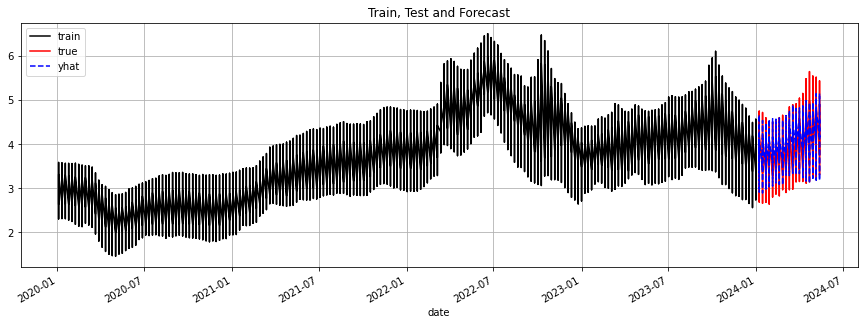

In [ ]:
plot_train_test_forecast(
    df_train,
    forecasting,
    date_col="date",
    ytrue="price",
    yhat="yhat"
);

Out[381]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': 0.0005381158233718208,
  'mse': 38.63085770751277,
  'rmse': 6.215372692567419,
  'sred': -89.52747540283201,
  'pv_shap': 0.011268210597336292,
  'pv_norm': 0.13072467697181345,
  'k': 1})

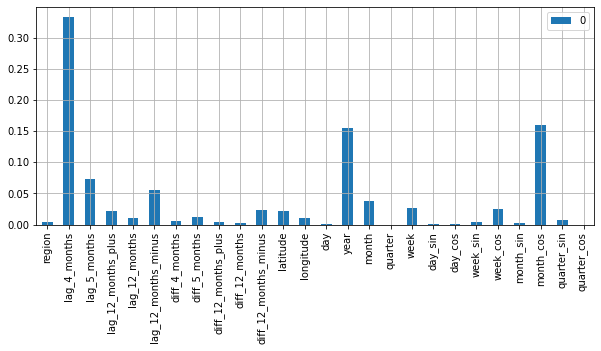

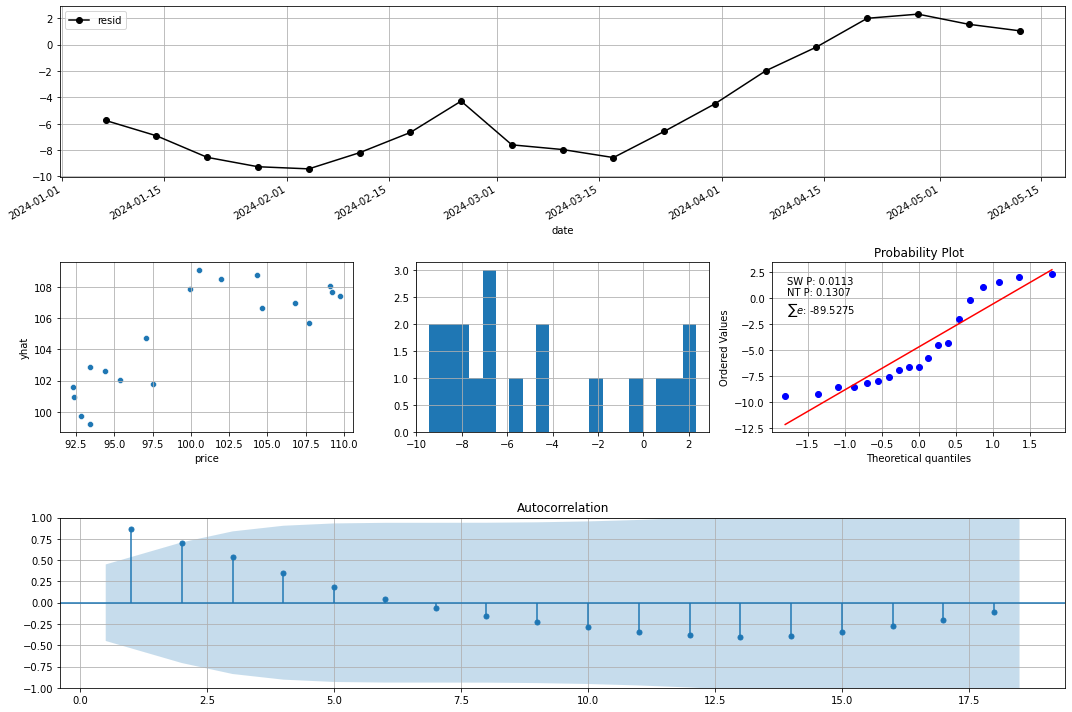

In [ ]:
pd.DataFrame(xgb.feature_importances_, xgb.feature_names_in_).plot(kind="bar", grid=2, figsize=(10, 4));

plot_resid_analysis(forecasting)


Lets take a look at "default" (or with minimal changes) XGBoost forecastings in future with a full training.

In [ ]:
forecasting = df8[f].copy()
dftp = df_test.copy()

with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-basic-full"
) as active_run:
    
    xgb = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=50,
        max_depth=5
    )

    xgb.fit(df8[~f].drop(columns=["date", "price", "future"]), df8[~f]["price"])

    mlflow.sklearn.log_model(xgb, "models/xgb_object")

In [ ]:
print(f"Model Run Id: {active_run.info.run_uuid}")

xgb_loaded = mlflow.pyfunc.load_model(
    f"runs:/{active_run.info.run_uuid}/models/xgb_object"
)

Model Run Id: db896680cd374477ac915847b0bb0b8e


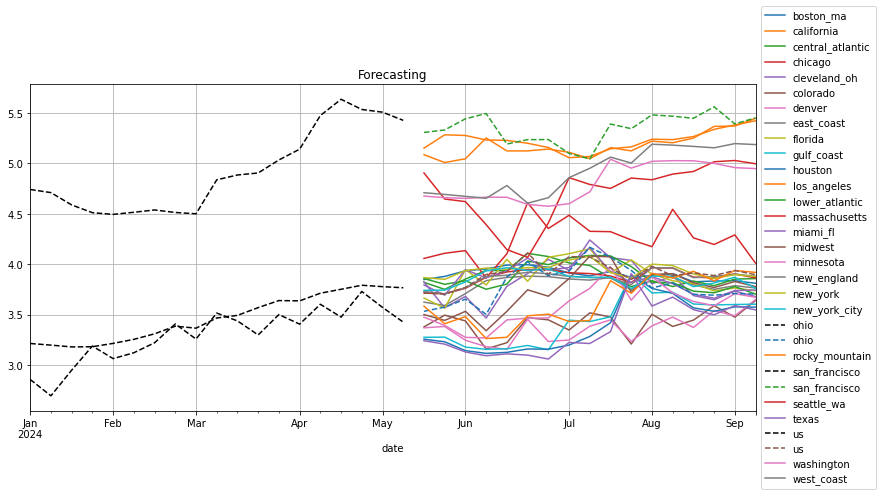

In [ ]:
yhat = xgb_loaded.predict(forecasting[xgb.feature_names_in_])

forecasting["price"] = yhat
forecasting["region"] = forecasting.region.map({v:k for k, v in region_mapping.items()})
dftp["region"] = dftp.region.map({v:k for k, v in region_mapping.items()})

plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);


##### 8.1.4.3. XGBoost Cross Validation

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-cv-basic"
) as active_run:
    xgb = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=50,
        max_depth=5
    )

    metrics = cv_mean_baseline(df_train, model=xgb, base_sklearn=True)
    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(metrics)
    log_mean_metrics[0].pop("estimator")
    log_std_metrics[0].pop("estimator")

    mlflow.log_metrics(log_mean_metrics[0])
    mlflow.log_metrics(log_std_metrics[0])


In [ ]:
desc_metrics

estimator 
 base 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 9.0 
 -0.992776 
 1.680338 
 -4.248843e+00 
 -2.263869e+00 
 -5.002519e-01 
 0.150784 
 0.814878 
 
 
 mse 
 9.0 
 0.548972 
 0.303350 
 7.151778e-02 
 4.357953e-01 
 6.733649e-01 
 0.703586 
 0.908988 
 
 
 rmse 
 9.0 
 0.701730 
 0.252223 
 2.674281e-01 
 6.601479e-01 
 8.205882e-01 
 0.838800 
 0.953408 
 
 
 sred 
 9.0 
 31.356392 
 291.079949 
 -3.791284e+02 
 -1.605901e+02 
 6.184862e+01 
 298.376054 
 383.933662 
 
 
 pv_shap 
 9.0 
 0.000579 
 0.001484 
 1.084991e-18 
 4.880870e-15 
 1.085539e-08 
 0.000002 
 0.004484 
 
 
 pv_norm 
 9.0 
 0.135437 
 0.269052 
 4.840433e-34 
 4.829388e-20 
 1.972777e-15 
 0.000069 
 0.635724 
 
 
 k 
 9.0 
 5.000000 
 2.738613 
 1.000000e+00 
 3.000000e+00 
 5.000000e+00 
 7.000000 
 9.000000


##### 8.1.4.4. XGBoost Fine Tuning

In [ ]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 25, 50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "gamma": trial.suggest_int("gamma", 0, 5),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 10),
    }

    xgb = XGBRegressor(**params)
    metrics = cv_mean_baseline(df_train, model=xgb, base_sklearn=True)
    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(metrics)

    return desc_metrics["base"]["mean"].loc["rmse"]

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

In [ ]:
print(study.best_value)

print(study.best_params)

0.6379165466513388
{'n_estimators': 43, 'learning_rate': 0.09121089166710909, 'min_child_weight': 8, 'subsample': 0.8950477741438344, 'max_depth': 3, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0}


In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-full"
) as active_run:
    xgb = XGBRegressor(**study.best_params)
    xgb.fit(x_train, y_train)
    yhat = xgb.predict(x_test)

    forecasting = pd.DataFrame({"yhat": yhat, "price": y_test, "date": df_test["date"].values})
    metrics = get_ml_metrics(forecasting, ytrue="price", yhat="yhat")
    print(pd.DataFrame(metrics, index=[0]))

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(xgb, "models/xgb_object")

         r2       mse      rmse       sred   pv_shap   pv_norm  k
0  0.776375  0.087082  0.295097 -48.058259  0.007477  0.044911  1


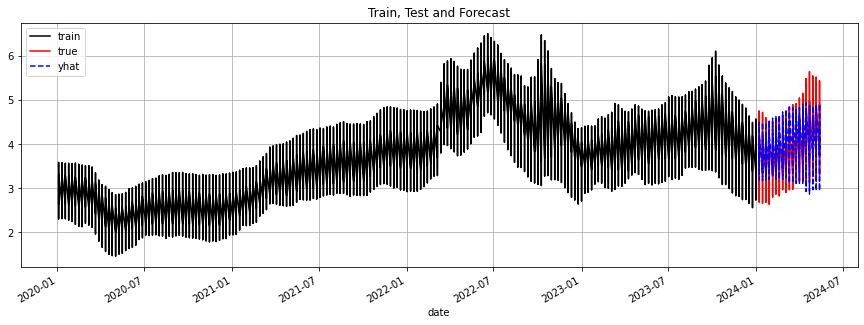

In [ ]:
plot_train_test_forecast(
    df_train,
    forecasting,
    date_col="date",
    ytrue="price",
    yhat="yhat"
);

Out[428]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': 0.11401127146934009,
  'mse': 34.24493224223793,
  'rmse': 5.851916971577598,
  'sred': -48.05825238037107,
  'pv_shap': 0.0030179843306541443,
  'pv_norm': 0.1634470834235398,
  'k': 1})

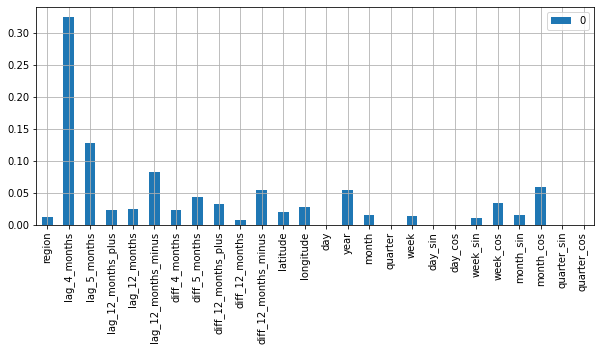

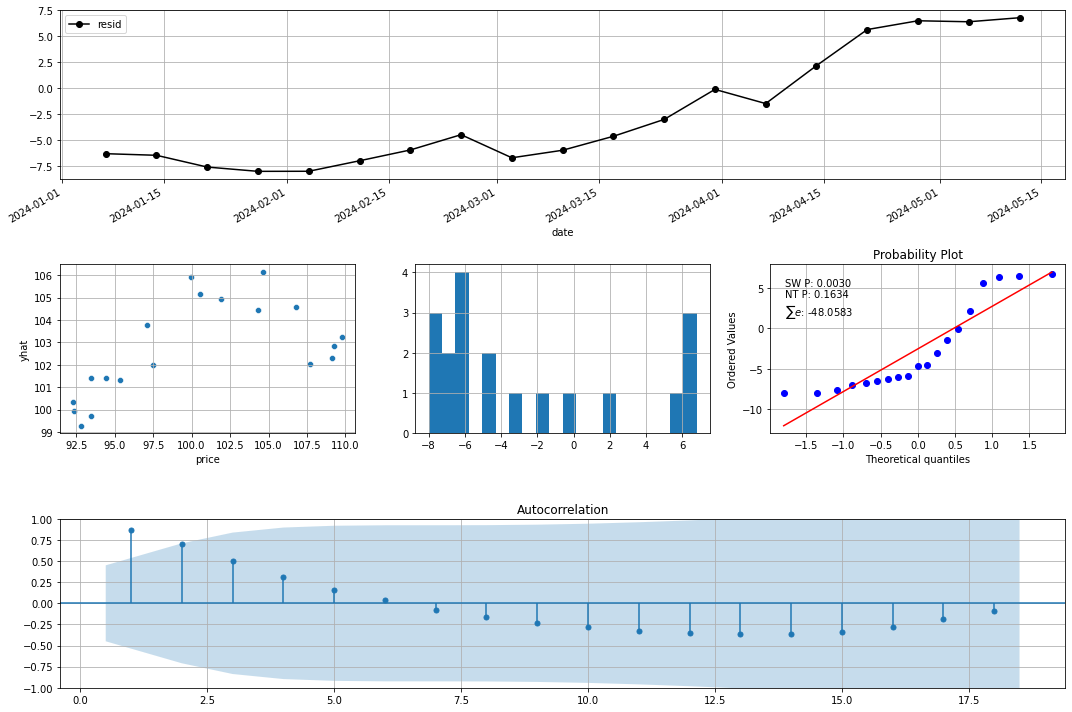

In [ ]:
pd.DataFrame(xgb.feature_importances_, xgb.feature_names_in_).plot(kind="bar", grid=2, figsize=(10, 4));

plot_resid_analysis(forecasting)

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-full-deploy"
) as active_run:
    xgb = XGBRegressor(**study.best_params)
    xgb.fit(df8[~f].drop(columns=["date", "price", "future"]), df8[~f]["price"])
    mlflow.sklearn.log_model(xgb, "models/xgb_object")


##### 8.1.4.5. XGBoost Future Forecasting


The standard xgb created previously has forecasts for the 4 months that are more consistent than the tuned XGB..

In [ ]:
forecasting = df8[f].copy()
dftp = df_test.copy()

In [ ]:
print(f"Model Run Id: {active_run.info.run_uuid}")

xgb_loaded = mlflow.pyfunc.load_model(
    f"runs:/{active_run.info.run_uuid}/models/xgb_object"
)

yhat = xgb_loaded.predict(forecasting[xgb.feature_names_in_])
forecasting["price"] = yhat

forecasting["region"] = forecasting.region.map({v:k for k, v in region_mapping.items()})
dftp["region"] = dftp.region.map({v:k for k, v in region_mapping.items()})

Model Run Id: 98d9b03802b747a0ae2b38d9ddc46790


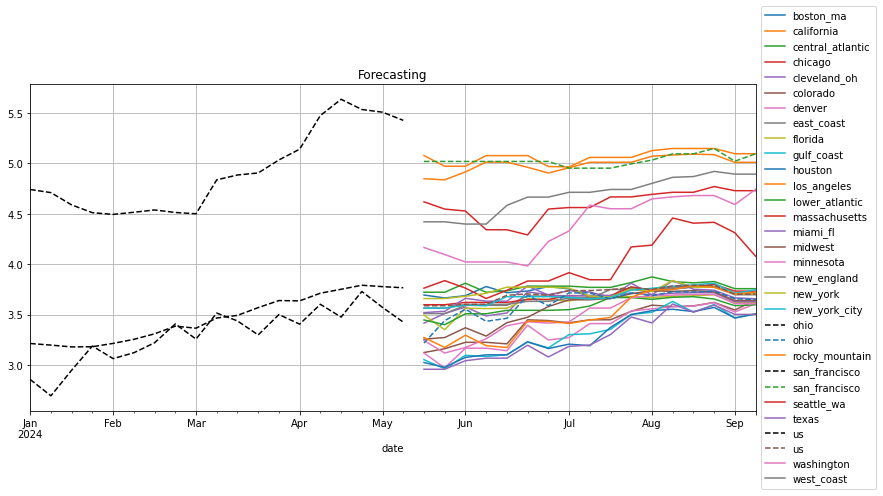

In [ ]:
plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);


### 8.1. Stacking Forecasting


I will combine the forecasting with base XGB and base MSTL.

In [ ]:
forecasting = df8[f].copy()
dftp = df_test.copy()
dftp["region"] = dftp.region.map({v:k for k, v in region_mapping.items()})

xgb_feature_list = [
    'region', 'lag_4_months', 'lag_5_months', 'lag_12_months_plus',
    'lag_12_months', 'lag_12_months_minus', 'diff_4_months',
    'diff_5_months', 'diff_12_months_plus', 'diff_12_months',
    'diff_12_months_minus', 'latitude', 'longitude', 'day', 'year',
    'month', 'quarter', 'week', 'day_sin', 'day_cos', 'week_sin',
    'week_cos', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos'
]

In [ ]:
xgb_loaded = mlflow.pyfunc.load_model("runs:/db896680cd374477ac915847b0bb0b8e/models/xgb_object")
mstl_loaded = mlflow.pyfunc.load_model("runs:/f468cab04a9e4371a71a9a68c9d459bf/models/sf_object")

df_mstl = mstl_loaded.predict(forecasting["date"].nunique()).reset_index()
df_mstl.rename(columns={"unique_id": "region", "ds": "date", "MSTL": "price"}, inplace=True)

xgb_yhat = xgb_loaded.predict(forecasting[xgb_feature_list])
forecasting["price"] = xgb_yhat

forecasting["region"] = forecasting["region"].map({v: k for k, v in region_mapping.items()})
forecasting = forecasting[["region", "date", "price"]]

# Sorting both to mean the series forecasts
forecasting = forecasting.sort_values(by=["date", "region"]).reset_index(drop=True)
df_mstl = df_mstl.sort_values(by=["date", "region"]).reset_index(drop=True)

forecasting["price"] = (df_mstl["price"] + forecasting["price"]) / 2

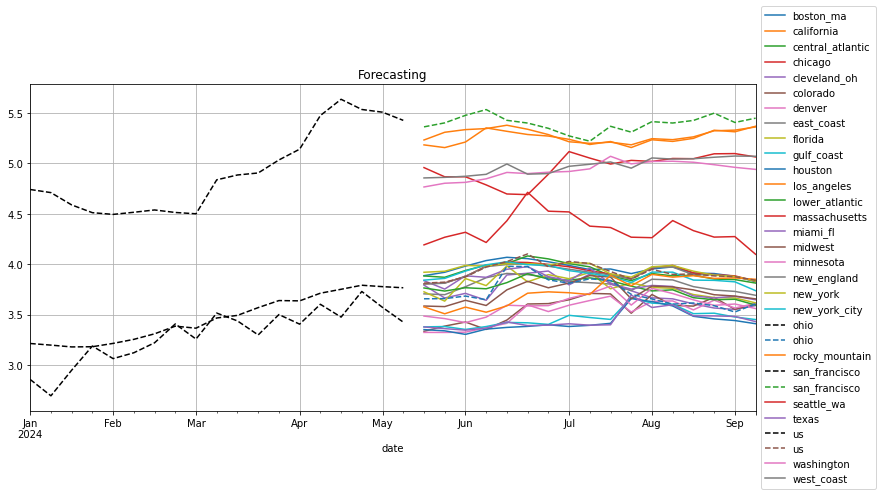

In [ ]:
plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);